In [145]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier
import numpy as np
import pandas as pd
from sklearn.ensemble import AdaBoostRegressor
from sklearn.feature_selection import SelectFwe, f_regression
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import PolynomialFeatures
from tpot.builtins import OneHotEncoder, StackingEstimator

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sample/gender_Binary_Classification_submission.csv
/kaggle/input/janatahack/train_8wry4cB.csv
/kaggle/input/janatahack/test_Yix80N0.csv
/kaggle/input/janatahack/sample_submission_opxHi4g.csv


In [146]:
train = pd.read_csv('/kaggle/input/janatahack/train_8wry4cB.csv')
test = pd.read_csv('/kaggle/input/janatahack/test_Yix80N0.csv')
sample = pd.read_csv('/kaggle/input/janatahack/sample_submission_opxHi4g.csv')

In [147]:
print(train.shape)
print(train.info)

(10500, 5)
<bound method DataFrame.info of       session_id       startTime         endTime  \
0         u16159  15/12/14 18:11  15/12/14 18:12   
1         u10253  16/12/14 14:35  16/12/14 14:41   
2         u19037  01/12/14 15:58  01/12/14 15:58   
3         u14556   23/11/14 2:57   23/11/14 3:00   
4         u24295  17/12/14 16:44  17/12/14 16:46   
...          ...             ...             ...   
10495     u15442   18/11/14 7:39   18/11/14 7:42   
10496     u17986  25/11/14 15:16  25/11/14 15:16   
10497     u22508  09/12/14 10:11  09/12/14 10:11   
10498     u17087  22/11/14 11:27  22/11/14 11:27   
10499     u23137   19/12/14 3:11   19/12/14 3:19   

                                             ProductList  gender  
0      A00002/B00003/C00006/D28435/;A00002/B00003/C00...  female  
1      A00001/B00009/C00031/D29404/;A00001/B00009/C00...    male  
2                           A00002/B00001/C00020/D16944/  female  
3      A00002/B00004/C00018/D10284/;A00002/B00004/C00...  female

In [148]:
train.apply(lambda x:len(x.unique()))

session_id     10500
startTime       8815
endTime         8803
ProductList     9402
gender             2
dtype: int64

Gender - Male and Female
Unique session id
9402 unique products

In [149]:
train.isna().sum()

session_id     0
startTime      0
endTime        0
ProductList    0
gender         0
dtype: int64

No null values

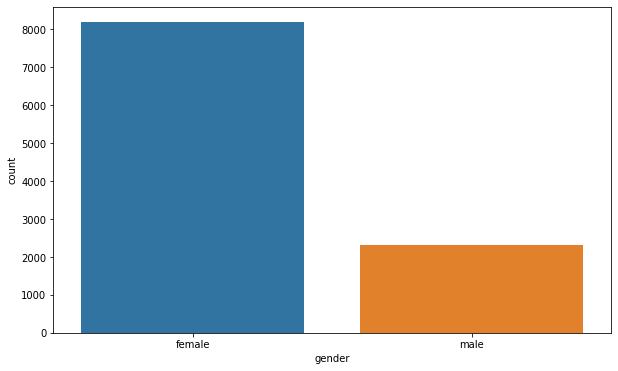

In [150]:
sns.countplot(train['gender'])

More females view then male

In [151]:
train['startTime'] = pd.to_datetime(train['startTime'])
train['endTime'] = pd.to_datetime(train['endTime'])

In [ ]:
train

We could also see that there is some inconsitency in start and end time

In [152]:
df = train.append(test)

In [153]:
df = df[['session_id','startTime','endTime','ProductList','gender']]

In [154]:
df['ProductCount'] = df.ProductList.str.count(';')+1

In [68]:
df['ProductList']

0       A00002/B00003/C00006/D28435/;A00002/B00003/C00...
1       A00001/B00009/C00031/D29404/;A00001/B00009/C00...
2                            A00002/B00001/C00020/D16944/
3       A00002/B00004/C00018/D10284/;A00002/B00004/C00...
4       A00001/B00001/C00012/D30805/;A00001/B00001/C00...
                              ...                        
4495    A00001/B00031/C00044/D03435/;A00001/B00031/C00...
4496    A00002/B00002/C00004/D17474/;A00002/B00002/C00...
4497    A00002/B00007/C00098/D03350/;A00002/B00007/C00...
4498                         A00001/B00031/C00044/D09604/
4499    A00002/B00002/C00003/D20004/;A00002/B00002/C00...
Name: ProductList, Length: 15000, dtype: object

In [155]:
df['startTime'] = pd.to_datetime(df['startTime'])
df['endTime'] = pd.to_datetime(df['endTime'])

In [156]:
import numpy as np
from itertools import chain

# return list from series of comma-separated strings
def chainer(s):
    return list(chain.from_iterable(s.str.split(';')))

# calculate lengths of splits
lens = df['ProductList'].str.split(';').map(len)

# create new dataframe, repeating or chaining as appropriate
df1 = pd.DataFrame({'session_id': np.repeat(df['session_id'], lens),
                    'startTime': np.repeat(df['startTime'], lens),
                    'endTime':np.repeat(df['endTime'],lens),
                    'ProductCount': np.repeat(df['ProductCount'], lens),
                    'ProductList': chainer(df['ProductList']),
                    'gender':np.repeat(df['gender'],lens)})

print(df1)

     session_id           startTime             endTime  ProductCount  \
0        u16159 2014-12-15 18:11:00 2014-12-15 18:12:00             4   
0        u16159 2014-12-15 18:11:00 2014-12-15 18:12:00             4   
0        u16159 2014-12-15 18:11:00 2014-12-15 18:12:00             4   
0        u16159 2014-12-15 18:11:00 2014-12-15 18:12:00             4   
1        u10253 2014-12-16 14:35:00 2014-12-16 14:41:00             7   
...         ...                 ...                 ...           ...   
4497     u13253 2014-11-15 21:38:00 2014-11-15 21:46:00             9   
4497     u13253 2014-11-15 21:38:00 2014-11-15 21:46:00             9   
4498     u17094 2014-12-17 08:51:00 2014-12-17 08:51:00             1   
4499     u24310 2014-12-17 17:25:00 2014-12-17 17:26:00             2   
4499     u24310 2014-12-17 17:25:00 2014-12-17 17:26:00             2   

                       ProductList  gender  
0     A00002/B00003/C00006/D28435/  female  
0     A00002/B00003/C00006/D02554

In [107]:
df1.head()

,session_id,startTime,endTime,ProductCount,ProductList,gender
0,u16159,2014-12-15 18:11:00,2014-12-15 18:12:00,4,A00002/B00003/C00006/D28435/,female
0,u16159,2014-12-15 18:11:00,2014-12-15 18:12:00,4,A00002/B00003/C00006/D02554/,female
0,u16159,2014-12-15 18:11:00,2014-12-15 18:12:00,4,A00002/B00003/C00006/D28436/,female
0,u16159,2014-12-15 18:11:00,2014-12-15 18:12:00,4,A00002/B00003/C00006/D28437/,female
1,u10253,2014-12-16 14:35:00,2014-12-16 14:41:00,7,A00001/B00009/C00031/D29404/,male


In [157]:
df1['TimeTaken'] = abs(df1['endTime'] - df1['startTime']).astype('timedelta64[m]')

In [158]:
df1[['Date','Time']] = df1['startTime'].astype(str).str.split(" ",expand=True) 

In [159]:
df1['Date'] = pd.to_datetime(df1['Date'])

In [160]:
df1['Day'] = df1['Date'].apply(lambda x: x.weekday())

In [109]:
df1.head()

,session_id,startTime,endTime,ProductCount,ProductList,gender,TimeTaken
0,u16159,2014-12-15 18:11:00,2014-12-15 18:12:00,4,A00002/B00003/C00006/D28435/,female,1.0
0,u16159,2014-12-15 18:11:00,2014-12-15 18:12:00,4,A00002/B00003/C00006/D02554/,female,1.0
0,u16159,2014-12-15 18:11:00,2014-12-15 18:12:00,4,A00002/B00003/C00006/D28436/,female,1.0
0,u16159,2014-12-15 18:11:00,2014-12-15 18:12:00,4,A00002/B00003/C00006/D28437/,female,1.0
1,u10253,2014-12-16 14:35:00,2014-12-16 14:41:00,7,A00001/B00009/C00031/D29404/,male,6.0


In [ ]:
df1['TimeTaken'].max()

In [161]:
df1[['Category','SubCategory','SubSubCategory','SubSubSubCategory','Extra']] = df1['ProductList'].str.split("/",expand=True) 

In [162]:
del df1['Extra']
del df1['ProductList']


In [163]:
del df1['Time']
del df1['Date']

In [64]:
len(df1['session_id'].unique())

15000

Changing the orders

In [164]:
df1.columns

Index(['session_id', 'startTime', 'endTime', 'ProductCount', 'gender',
       'TimeTaken', 'Day', 'Category', 'SubCategory', 'SubSubCategory',
       'SubSubSubCategory'],
      dtype='object')

In [165]:
df1 = df1[['session_id','TimeTaken','Day','ProductCount','Category','SubCategory','SubSubCategory','SubSubSubCategory','gender']]

In [166]:
df1['TimeTaken'] = df1.TimeTaken.apply(lambda x:int(x))

In [81]:
df1.head()

,session_id,TimeTaken,Day,ProductCount,Category,SubCategory,SubSubCategory,SubSubSubCategory,gender
0,u16159,1,0,4,A00002,B00003,C00006,D28435,female
0,u16159,1,0,4,A00002,B00003,C00006,D02554,female
0,u16159,1,0,4,A00002,B00003,C00006,D28436,female
0,u16159,1,0,4,A00002,B00003,C00006,D28437,female
1,u10253,6,1,7,A00001,B00009,C00031,D29404,male


In [167]:
from sklearn import preprocessing 
columns = ['Category','SubCategory','SubSubCategory','SubSubSubCategory']
label_encoder = preprocessing.LabelEncoder() 
  
for i in columns:
    df1[i]= label_encoder.fit_transform(df1[i]) 
  

In [ ]:
df1['session_id'].describe()

In [168]:
test1 = df1[df1['gender'].isnull() == True]

In [169]:
train1 = df1[df1['gender'].isnull() == False]


In [170]:
train1.head()

,session_id,TimeTaken,Day,ProductCount,Category,SubCategory,SubSubCategory,SubSubSubCategory,gender
0,u16159,1,0,4,1,2,5,17574,female
0,u16159,1,0,4,1,2,5,1789,female
0,u16159,1,0,4,1,2,5,17575,female
0,u16159,1,0,4,1,2,5,17576,female
1,u10253,6,1,7,0,8,30,18146,male


In [87]:
test1.head()

,session_id,TimeTaken,Day,ProductCount,Category,SubCategory,SubSubCategory,SubSubSubCategory,gender
0,u12112,0,1,1,1,2,5,12675,NaN
1,u19725,0,4,1,1,4,66,1407,NaN
2,u11795,0,6,1,1,1,3,8129,NaN
3,u22639,3,1,4,1,2,77,14345,NaN
3,u22639,3,1,4,1,2,77,14346,NaN


In [171]:
from sklearn import preprocessing 
columns = ['gender']
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 
  
for i in columns:
    train1[i]= label_encoder.fit_transform(train1[i]) 
  

In [ ]:
train1.corr()

In [ ]:
sns.countplot(train1['Category'])

In [ ]:
sns.countplot(train1['Day'])

In [ ]:
train1.groupby('Day')['gender'].size()

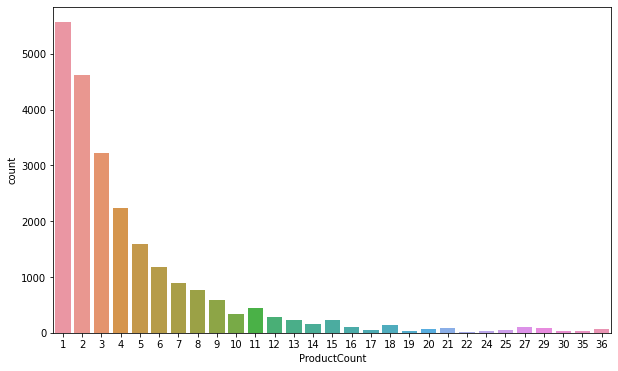

In [89]:
sns.countplot(train1['ProductCount'])

In [ ]:
pd.crosstab(train1['Day'],train1['gender'])

In [172]:
del test1['gender']

In [173]:
def extra_tree(Xtrain,Ytrain,Xtest):
    extra = ExtraTreesClassifier()
    extra.fit(Xtrain, Ytrain) 
    extra_prediction = extra.predict(Xtest)
    return extra_prediction
def Xg_boost(Xtrain,Ytrain,Xtest):
    xg = XGBClassifier(loss='exponential', learning_rate=0.05, n_estimators=1000, subsample=1.0, criterion='friedman_mse', 
                                  min_samples_split=2, 
                                  min_samples_leaf=5, min_weight_fraction_leaf=0.0, max_depth=10, min_impurity_decrease=0.0, 
                                  min_impurity_split=None, 
                                  init=None, random_state=None, max_features=None, verbose=1, max_leaf_nodes=None, warm_start=False, 
                                  presort='deprecated', 
                                  validation_fraction=0.1, n_iter_no_change=None, tol=0.0001)
    xg.fit(Xtrain, Ytrain) 
    xg_prediction = xg.predict(Xtest)
    return xg_prediction
def LGBM(Xtrain,Ytrain,Xtest):
    lgbm = LGBMClassifier(boosting_type='gbdt', num_leaves=40,
                            max_depth=5, learning_rate=0.05, n_estimators=1000, subsample_for_bin=200, objective='binary', 
                            min_split_gain=0.0, min_child_weight=0.001, min_child_samples=10,
                            subsample=1.0, subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0,
                            reg_lambda=0.0, random_state=None, n_jobs=1, silent=True, importance_type='split')
    #lgbm = LGBMClassifier(n_estimators= 500)
    lgbm.fit(X_train, Y_train)
    lgbm_preds = lgbm.predict(X_test)
    return lgbm_preds

In [ ]:
print(train1.columns)
print(test1.columns)

In [174]:
X_train = train1[['TimeTaken','Day','ProductCount','Category', 'SubCategory', 'SubSubCategory','SubSubSubCategory']]
Y_train = train1['gender']
X_test = test1[['TimeTaken','Day','ProductCount', 'Category', 'SubCategory', 'SubSubCategory','SubSubSubCategory']]

In [133]:
from autoviml.Auto_ViML import Auto_ViML

In [31]:
target = 'gender'
scoring_parameter = 'balanced-accuracy'

##############  D A T A   S E T  A N A L Y S I S  #######################
Train (Size: 23251,8) has Single_Label with target: ['gender']
Shuffling the data set before training
 Class  -> Counts -> Percent
     0:   18410  ->   79.2%
     1:    4841  ->   20.8%
Using GridSearchCV for Hyper Parameter Tuning. This is slow. Switch to RS for faster tuning...
    Target gender is already numeric. No transformation done.
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
    7 Predictors classified...
        This does not include the Target column(s)
    No variables removed since no ID or low-information variables found in data set
Number of GPUs = 2
No GPU available on this device
#############     D A T A    P R E P A R A T I O N     #############
No Missing Values in train data set
Test data has no missing values. Continuing...
Completed Scaling of Train and Test Data using MinMaxScaler(copy=True, feature_range=(0, 1)) ...
B

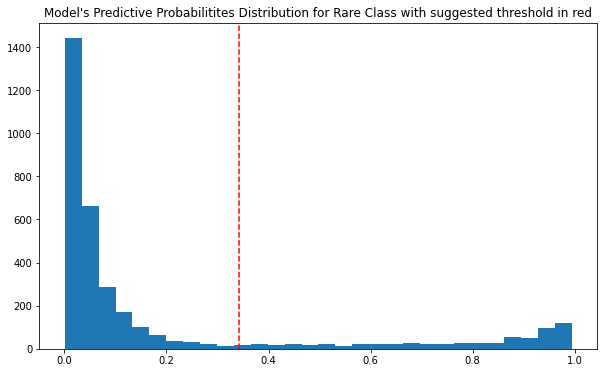

In [34]:

m, feats, trainm, testm = Auto_ViML(train1, target, test1,
                                    scoring_parameter=scoring_parameter,
                                    hyper_param='GS',feature_reduction=True,
                                     Boosting_Flag='Boosting_Flag',Binning_Flag=False)

In [43]:
sam = pd.read_csv('/kaggle/input/sample/gender_Binary_Classification_submission.csv')

In [46]:

test1['gender'] = sam['gender_predictions']
testn = test1[['session_id','gender']]
print(testn.isna().sum())
test_final = testn.drop_duplicates(subset='session_id', keep='first', inplace=False)
dic = {1:'male',0:'female'}
test_final['gender'] = test_final['gender'].map(dic)
test_final.to_csv('Auto.csv',index = False)

session_id    0
gender        0
dtype: int64


In [134]:
X_train.head()
cate_features_index = np.where(X_train.dtypes != float)[0]

In [135]:
xtrain,xtest,ytrain,ytest = train_test_split(X_train,Y_train,train_size=0.99,random_state=1236)

In [136]:
from catboost import Pool, CatBoostClassifier, cv, CatBoostRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [137]:
model = CatBoostClassifier(iterations=7000, learning_rate=0.001, l2_leaf_reg=3.5, depth=5, 
                           rsm=0.99, loss_function= 'Logloss', eval_metric='AUC',use_best_model=True,random_seed=50)

In [138]:
model.fit(xtrain,ytrain,cat_features=cate_features_index,eval_set=(xtest,ytest))

0:	test: 0.6614159	best: 0.6614159 (0)	total: 28.1ms	remaining: 3m 16s
1:	test: 0.6506626	best: 0.6614159 (0)	total: 59ms	remaining: 3m 26s
2:	test: 0.6636247	best: 0.6636247 (2)	total: 77.4ms	remaining: 3m
3:	test: 0.6526970	best: 0.6636247 (2)	total: 105ms	remaining: 3m 3s
4:	test: 0.6762962	best: 0.6762962 (4)	total: 125ms	remaining: 2m 54s
5:	test: 0.6760637	best: 0.6762962 (4)	total: 146ms	remaining: 2m 49s
6:	test: 0.6953034	best: 0.6953034 (6)	total: 169ms	remaining: 2m 49s
7:	test: 0.7165194	best: 0.7165194 (7)	total: 191ms	remaining: 2m 46s
8:	test: 0.7079168	best: 0.7165194 (7)	total: 214ms	remaining: 2m 46s
9:	test: 0.7227970	best: 0.7227970 (9)	total: 242ms	remaining: 2m 49s
10:	test: 0.7054755	best: 0.7227970 (9)	total: 265ms	remaining: 2m 48s
11:	test: 0.7102418	best: 0.7227970 (9)	total: 281ms	remaining: 2m 43s
12:	test: 0.7085561	best: 0.7227970 (9)	total: 303ms	remaining: 2m 43s
13:	test: 0.7079749	best: 0.7227970 (9)	total: 317ms	remaining: 2m 38s
14:	test: 0.7094862	

117:	test: 0.7611021	best: 0.7645896 (108)	total: 2.8s	remaining: 2m 43s
118:	test: 0.7607533	best: 0.7645896 (108)	total: 2.83s	remaining: 2m 43s
119:	test: 0.7600558	best: 0.7645896 (108)	total: 2.85s	remaining: 2m 43s
120:	test: 0.7615671	best: 0.7645896 (108)	total: 2.87s	remaining: 2m 43s
121:	test: 0.7617996	best: 0.7645896 (108)	total: 2.89s	remaining: 2m 42s
122:	test: 0.7609858	best: 0.7645896 (108)	total: 2.91s	remaining: 2m 42s
123:	test: 0.7606371	best: 0.7645896 (108)	total: 2.93s	remaining: 2m 42s
124:	test: 0.7605208	best: 0.7645896 (108)	total: 2.95s	remaining: 2m 42s
125:	test: 0.7605208	best: 0.7645896 (108)	total: 2.97s	remaining: 2m 41s
126:	test: 0.7605208	best: 0.7645896 (108)	total: 2.99s	remaining: 2m 41s
127:	test: 0.7606371	best: 0.7645896 (108)	total: 3.01s	remaining: 2m 41s
128:	test: 0.7602883	best: 0.7645896 (108)	total: 3.03s	remaining: 2m 41s
129:	test: 0.7599395	best: 0.7645896 (108)	total: 3.04s	remaining: 2m 40s
130:	test: 0.7600558	best: 0.7645896 (1

231:	test: 0.7635434	best: 0.7651709 (167)	total: 5.12s	remaining: 2m 29s
232:	test: 0.7635434	best: 0.7651709 (167)	total: 5.14s	remaining: 2m 29s
233:	test: 0.7636596	best: 0.7651709 (167)	total: 5.16s	remaining: 2m 29s
234:	test: 0.7642409	best: 0.7651709 (167)	total: 5.17s	remaining: 2m 28s
235:	test: 0.7642409	best: 0.7651709 (167)	total: 5.2s	remaining: 2m 28s
236:	test: 0.7652871	best: 0.7652871 (236)	total: 5.22s	remaining: 2m 28s
237:	test: 0.7652871	best: 0.7652871 (236)	total: 5.24s	remaining: 2m 28s
238:	test: 0.7651709	best: 0.7652871 (236)	total: 5.26s	remaining: 2m 28s
239:	test: 0.7651709	best: 0.7652871 (236)	total: 5.28s	remaining: 2m 28s
240:	test: 0.7650546	best: 0.7652871 (236)	total: 5.29s	remaining: 2m 28s
241:	test: 0.7651709	best: 0.7652871 (236)	total: 5.32s	remaining: 2m 28s
242:	test: 0.7651709	best: 0.7652871 (236)	total: 5.34s	remaining: 2m 28s
243:	test: 0.7644734	best: 0.7652871 (236)	total: 5.36s	remaining: 2m 28s
244:	test: 0.7645896	best: 0.7652871 (2

344:	test: 0.7676122	best: 0.7678447 (309)	total: 7.65s	remaining: 2m 27s
345:	test: 0.7674959	best: 0.7678447 (309)	total: 7.67s	remaining: 2m 27s
346:	test: 0.7676122	best: 0.7678447 (309)	total: 7.69s	remaining: 2m 27s
347:	test: 0.7677284	best: 0.7678447 (309)	total: 7.71s	remaining: 2m 27s
348:	test: 0.7676122	best: 0.7678447 (309)	total: 7.73s	remaining: 2m 27s
349:	test: 0.7673797	best: 0.7678447 (309)	total: 7.75s	remaining: 2m 27s
350:	test: 0.7671472	best: 0.7678447 (309)	total: 7.77s	remaining: 2m 27s
351:	test: 0.7671472	best: 0.7678447 (309)	total: 7.79s	remaining: 2m 27s
352:	test: 0.7680772	best: 0.7680772 (352)	total: 7.81s	remaining: 2m 27s
353:	test: 0.7680772	best: 0.7680772 (352)	total: 7.83s	remaining: 2m 27s
354:	test: 0.7680772	best: 0.7680772 (352)	total: 7.85s	remaining: 2m 26s
355:	test: 0.7679609	best: 0.7680772 (352)	total: 7.87s	remaining: 2m 26s
356:	test: 0.7679609	best: 0.7680772 (352)	total: 7.89s	remaining: 2m 26s
357:	test: 0.7678447	best: 0.7680772 (

458:	test: 0.7687747	best: 0.7693560 (380)	total: 9.99s	remaining: 2m 22s
459:	test: 0.7687747	best: 0.7693560 (380)	total: 10s	remaining: 2m 22s
460:	test: 0.7707510	best: 0.7707510 (460)	total: 10s	remaining: 2m 22s
461:	test: 0.7707510	best: 0.7707510 (460)	total: 10s	remaining: 2m 22s
462:	test: 0.7708672	best: 0.7708672 (462)	total: 10.1s	remaining: 2m 22s
463:	test: 0.7707510	best: 0.7708672 (462)	total: 10.1s	remaining: 2m 22s
464:	test: 0.7708672	best: 0.7708672 (462)	total: 10.1s	remaining: 2m 22s
465:	test: 0.7707510	best: 0.7708672 (462)	total: 10.1s	remaining: 2m 22s
466:	test: 0.7707510	best: 0.7708672 (462)	total: 10.1s	remaining: 2m 21s
467:	test: 0.7706347	best: 0.7708672 (462)	total: 10.2s	remaining: 2m 21s
468:	test: 0.7708672	best: 0.7708672 (462)	total: 10.2s	remaining: 2m 21s
469:	test: 0.7708672	best: 0.7708672 (462)	total: 10.2s	remaining: 2m 21s
470:	test: 0.7730760	best: 0.7730760 (470)	total: 10.2s	remaining: 2m 21s
471:	test: 0.7727273	best: 0.7730760 (470)	t

571:	test: 0.7730760	best: 0.7735410 (556)	total: 12.3s	remaining: 2m 18s
572:	test: 0.7736573	best: 0.7736573 (572)	total: 12.3s	remaining: 2m 18s
573:	test: 0.7736573	best: 0.7736573 (572)	total: 12.3s	remaining: 2m 18s
574:	test: 0.7734248	best: 0.7736573 (572)	total: 12.3s	remaining: 2m 18s
575:	test: 0.7751686	best: 0.7751686 (575)	total: 12.4s	remaining: 2m 17s
576:	test: 0.7752848	best: 0.7752848 (576)	total: 12.4s	remaining: 2m 17s
577:	test: 0.7752848	best: 0.7752848 (576)	total: 12.4s	remaining: 2m 17s
578:	test: 0.7752848	best: 0.7752848 (576)	total: 12.4s	remaining: 2m 17s
579:	test: 0.7751686	best: 0.7752848 (576)	total: 12.5s	remaining: 2m 17s
580:	test: 0.7750523	best: 0.7752848 (576)	total: 12.5s	remaining: 2m 17s
581:	test: 0.7745873	best: 0.7752848 (576)	total: 12.5s	remaining: 2m 17s
582:	test: 0.7745873	best: 0.7752848 (576)	total: 12.5s	remaining: 2m 17s
583:	test: 0.7750523	best: 0.7752848 (576)	total: 12.5s	remaining: 2m 17s
584:	test: 0.7750523	best: 0.7752848 (

689:	test: 0.8069054	best: 0.8069054 (689)	total: 14.6s	remaining: 2m 13s
690:	test: 0.8069054	best: 0.8069054 (689)	total: 14.6s	remaining: 2m 13s
691:	test: 0.8077191	best: 0.8077191 (691)	total: 14.7s	remaining: 2m 13s
692:	test: 0.8074866	best: 0.8077191 (691)	total: 14.7s	remaining: 2m 13s
693:	test: 0.8072541	best: 0.8077191 (691)	total: 14.7s	remaining: 2m 13s
694:	test: 0.8073704	best: 0.8077191 (691)	total: 14.7s	remaining: 2m 13s
695:	test: 0.8076029	best: 0.8077191 (691)	total: 14.7s	remaining: 2m 13s
696:	test: 0.8076029	best: 0.8077191 (691)	total: 14.8s	remaining: 2m 13s
697:	test: 0.8085329	best: 0.8085329 (697)	total: 14.8s	remaining: 2m 13s
698:	test: 0.8085329	best: 0.8085329 (697)	total: 14.8s	remaining: 2m 13s
699:	test: 0.8087654	best: 0.8087654 (699)	total: 14.8s	remaining: 2m 13s
700:	test: 0.8087654	best: 0.8087654 (699)	total: 14.8s	remaining: 2m 13s
701:	test: 0.8088817	best: 0.8088817 (701)	total: 14.9s	remaining: 2m 13s
702:	test: 0.8088817	best: 0.8088817 (

804:	test: 0.8206231	best: 0.8208556 (791)	total: 17s	remaining: 2m 10s
805:	test: 0.8205069	best: 0.8208556 (791)	total: 17s	remaining: 2m 10s
806:	test: 0.8206231	best: 0.8208556 (791)	total: 17s	remaining: 2m 10s
807:	test: 0.8205069	best: 0.8208556 (791)	total: 17s	remaining: 2m 10s
808:	test: 0.8203906	best: 0.8208556 (791)	total: 17s	remaining: 2m 10s
809:	test: 0.8206231	best: 0.8208556 (791)	total: 17.1s	remaining: 2m 10s
810:	test: 0.8208556	best: 0.8208556 (791)	total: 17.1s	remaining: 2m 10s
811:	test: 0.8221344	best: 0.8221344 (811)	total: 17.1s	remaining: 2m 10s
812:	test: 0.8221344	best: 0.8221344 (811)	total: 17.1s	remaining: 2m 10s
813:	test: 0.8222506	best: 0.8222506 (813)	total: 17.1s	remaining: 2m 10s
814:	test: 0.8214369	best: 0.8222506 (813)	total: 17.2s	remaining: 2m 10s
815:	test: 0.8227156	best: 0.8227156 (815)	total: 17.2s	remaining: 2m 10s
816:	test: 0.8231807	best: 0.8231807 (816)	total: 17.2s	remaining: 2m 10s
817:	test: 0.8238782	best: 0.8238782 (817)	total

918:	test: 0.8339921	best: 0.8339921 (912)	total: 19.2s	remaining: 2m 7s
919:	test: 0.8339921	best: 0.8339921 (912)	total: 19.3s	remaining: 2m 7s
920:	test: 0.8339921	best: 0.8339921 (912)	total: 19.3s	remaining: 2m 7s
921:	test: 0.8341083	best: 0.8341083 (921)	total: 19.3s	remaining: 2m 7s
922:	test: 0.8339921	best: 0.8341083 (921)	total: 19.3s	remaining: 2m 7s
923:	test: 0.8339921	best: 0.8341083 (921)	total: 19.3s	remaining: 2m 7s
924:	test: 0.8345734	best: 0.8345734 (924)	total: 19.4s	remaining: 2m 7s
925:	test: 0.8352709	best: 0.8352709 (925)	total: 19.4s	remaining: 2m 7s
926:	test: 0.8352709	best: 0.8352709 (925)	total: 19.4s	remaining: 2m 7s
927:	test: 0.8355034	best: 0.8355034 (927)	total: 19.4s	remaining: 2m 7s
928:	test: 0.8360846	best: 0.8360846 (928)	total: 19.4s	remaining: 2m 7s
929:	test: 0.8360846	best: 0.8360846 (928)	total: 19.5s	remaining: 2m 7s
930:	test: 0.8362009	best: 0.8362009 (930)	total: 19.5s	remaining: 2m 6s
931:	test: 0.8362009	best: 0.8362009 (930)	total: 1

1034:	test: 0.8418972	best: 0.8418972 (1023)	total: 21.6s	remaining: 2m 4s
1035:	test: 0.8417810	best: 0.8418972 (1023)	total: 21.6s	remaining: 2m 4s
1036:	test: 0.8420135	best: 0.8420135 (1036)	total: 21.6s	remaining: 2m 4s
1037:	test: 0.8418972	best: 0.8420135 (1036)	total: 21.6s	remaining: 2m 4s
1038:	test: 0.8418972	best: 0.8420135 (1036)	total: 21.6s	remaining: 2m 4s
1039:	test: 0.8418972	best: 0.8420135 (1036)	total: 21.7s	remaining: 2m 4s
1040:	test: 0.8417810	best: 0.8420135 (1036)	total: 21.7s	remaining: 2m 4s
1041:	test: 0.8418972	best: 0.8420135 (1036)	total: 21.7s	remaining: 2m 4s
1042:	test: 0.8420135	best: 0.8420135 (1036)	total: 21.7s	remaining: 2m 4s
1043:	test: 0.8420135	best: 0.8420135 (1036)	total: 21.7s	remaining: 2m 4s
1044:	test: 0.8422460	best: 0.8422460 (1044)	total: 21.8s	remaining: 2m 4s
1045:	test: 0.8422460	best: 0.8422460 (1044)	total: 21.8s	remaining: 2m 3s
1046:	test: 0.8423622	best: 0.8423622 (1046)	total: 21.8s	remaining: 2m 3s
1047:	test: 0.8423622	bes

1148:	test: 0.8464311	best: 0.8468961 (1141)	total: 23.9s	remaining: 2m 1s
1149:	test: 0.8464311	best: 0.8468961 (1141)	total: 23.9s	remaining: 2m 1s
1150:	test: 0.8465473	best: 0.8468961 (1141)	total: 23.9s	remaining: 2m 1s
1151:	test: 0.8463148	best: 0.8468961 (1141)	total: 23.9s	remaining: 2m 1s
1152:	test: 0.8467798	best: 0.8468961 (1141)	total: 23.9s	remaining: 2m 1s
1153:	test: 0.8468961	best: 0.8468961 (1141)	total: 24s	remaining: 2m 1s
1154:	test: 0.8468961	best: 0.8468961 (1141)	total: 24s	remaining: 2m 1s
1155:	test: 0.8468961	best: 0.8468961 (1141)	total: 24s	remaining: 2m 1s
1156:	test: 0.8468961	best: 0.8468961 (1141)	total: 24s	remaining: 2m 1s
1157:	test: 0.8470123	best: 0.8470123 (1157)	total: 24s	remaining: 2m 1s
1158:	test: 0.8470123	best: 0.8470123 (1157)	total: 24.1s	remaining: 2m 1s
1159:	test: 0.8470123	best: 0.8470123 (1157)	total: 24.1s	remaining: 2m 1s
1160:	test: 0.8470123	best: 0.8470123 (1157)	total: 24.1s	remaining: 2m 1s
1161:	test: 0.8470123	best: 0.84701

1264:	test: 0.8515462	best: 0.8515462 (1262)	total: 26.2s	remaining: 1m 58s
1265:	test: 0.8515462	best: 0.8515462 (1262)	total: 26.2s	remaining: 1m 58s
1266:	test: 0.8515462	best: 0.8515462 (1262)	total: 26.2s	remaining: 1m 58s
1267:	test: 0.8515462	best: 0.8515462 (1262)	total: 26.2s	remaining: 1m 58s
1268:	test: 0.8516624	best: 0.8516624 (1268)	total: 26.3s	remaining: 1m 58s
1269:	test: 0.8517787	best: 0.8517787 (1269)	total: 26.3s	remaining: 1m 58s
1270:	test: 0.8518949	best: 0.8518949 (1270)	total: 26.3s	remaining: 1m 58s
1271:	test: 0.8518949	best: 0.8518949 (1270)	total: 26.3s	remaining: 1m 58s
1272:	test: 0.8518949	best: 0.8518949 (1270)	total: 26.3s	remaining: 1m 58s
1273:	test: 0.8520112	best: 0.8520112 (1273)	total: 26.4s	remaining: 1m 58s
1274:	test: 0.8518949	best: 0.8520112 (1273)	total: 26.4s	remaining: 1m 58s
1275:	test: 0.8518949	best: 0.8520112 (1273)	total: 26.4s	remaining: 1m 58s
1276:	test: 0.8518949	best: 0.8520112 (1273)	total: 26.4s	remaining: 1m 58s
1277:	test: 

1377:	test: 0.8551500	best: 0.8552662 (1371)	total: 28.5s	remaining: 1m 56s
1378:	test: 0.8550337	best: 0.8552662 (1371)	total: 28.5s	remaining: 1m 56s
1379:	test: 0.8549175	best: 0.8552662 (1371)	total: 28.5s	remaining: 1m 56s
1380:	test: 0.8550337	best: 0.8552662 (1371)	total: 28.5s	remaining: 1m 56s
1381:	test: 0.8553825	best: 0.8553825 (1381)	total: 28.6s	remaining: 1m 56s
1382:	test: 0.8552662	best: 0.8553825 (1381)	total: 28.6s	remaining: 1m 56s
1383:	test: 0.8553825	best: 0.8553825 (1381)	total: 28.6s	remaining: 1m 56s
1384:	test: 0.8554987	best: 0.8554987 (1384)	total: 28.6s	remaining: 1m 56s
1385:	test: 0.8556150	best: 0.8556150 (1385)	total: 28.6s	remaining: 1m 55s
1386:	test: 0.8556150	best: 0.8556150 (1385)	total: 28.7s	remaining: 1m 55s
1387:	test: 0.8557312	best: 0.8557312 (1387)	total: 28.7s	remaining: 1m 55s
1388:	test: 0.8559637	best: 0.8559637 (1388)	total: 28.7s	remaining: 1m 55s
1389:	test: 0.8558475	best: 0.8559637 (1388)	total: 28.7s	remaining: 1m 55s
1390:	test: 

1492:	test: 0.8585213	best: 0.8585213 (1490)	total: 30.8s	remaining: 1m 53s
1493:	test: 0.8585213	best: 0.8585213 (1490)	total: 30.8s	remaining: 1m 53s
1494:	test: 0.8585213	best: 0.8585213 (1490)	total: 30.8s	remaining: 1m 53s
1495:	test: 0.8585213	best: 0.8585213 (1490)	total: 30.8s	remaining: 1m 53s
1496:	test: 0.8585213	best: 0.8585213 (1490)	total: 30.9s	remaining: 1m 53s
1497:	test: 0.8585213	best: 0.8585213 (1490)	total: 30.9s	remaining: 1m 53s
1498:	test: 0.8584050	best: 0.8585213 (1490)	total: 30.9s	remaining: 1m 53s
1499:	test: 0.8584050	best: 0.8585213 (1490)	total: 30.9s	remaining: 1m 53s
1500:	test: 0.8584050	best: 0.8585213 (1490)	total: 30.9s	remaining: 1m 53s
1501:	test: 0.8584050	best: 0.8585213 (1490)	total: 31s	remaining: 1m 53s
1502:	test: 0.8582888	best: 0.8585213 (1490)	total: 31s	remaining: 1m 53s
1503:	test: 0.8582888	best: 0.8585213 (1490)	total: 31s	remaining: 1m 53s
1504:	test: 0.8586375	best: 0.8586375 (1504)	total: 31s	remaining: 1m 53s
1505:	test: 0.858753

1607:	test: 0.8627063	best: 0.8628226 (1605)	total: 33.1s	remaining: 1m 50s
1608:	test: 0.8627063	best: 0.8628226 (1605)	total: 33.1s	remaining: 1m 50s
1609:	test: 0.8629389	best: 0.8629389 (1609)	total: 33.1s	remaining: 1m 50s
1610:	test: 0.8629389	best: 0.8629389 (1609)	total: 33.1s	remaining: 1m 50s
1611:	test: 0.8629389	best: 0.8629389 (1609)	total: 33.2s	remaining: 1m 50s
1612:	test: 0.8630551	best: 0.8630551 (1612)	total: 33.2s	remaining: 1m 50s
1613:	test: 0.8634039	best: 0.8634039 (1613)	total: 33.2s	remaining: 1m 50s
1614:	test: 0.8634039	best: 0.8634039 (1613)	total: 33.2s	remaining: 1m 50s
1615:	test: 0.8637526	best: 0.8637526 (1615)	total: 33.3s	remaining: 1m 50s
1616:	test: 0.8636364	best: 0.8637526 (1615)	total: 33.3s	remaining: 1m 50s
1617:	test: 0.8637526	best: 0.8637526 (1615)	total: 33.3s	remaining: 1m 50s
1618:	test: 0.8638689	best: 0.8638689 (1618)	total: 33.3s	remaining: 1m 50s
1619:	test: 0.8639851	best: 0.8639851 (1619)	total: 33.3s	remaining: 1m 50s
1620:	test: 

1719:	test: 0.8671239	best: 0.8674727 (1713)	total: 35.4s	remaining: 1m 48s
1720:	test: 0.8672402	best: 0.8674727 (1713)	total: 35.4s	remaining: 1m 48s
1721:	test: 0.8672402	best: 0.8674727 (1713)	total: 35.5s	remaining: 1m 48s
1722:	test: 0.8673564	best: 0.8674727 (1713)	total: 35.5s	remaining: 1m 48s
1723:	test: 0.8674727	best: 0.8674727 (1713)	total: 35.5s	remaining: 1m 48s
1724:	test: 0.8675889	best: 0.8675889 (1724)	total: 35.5s	remaining: 1m 48s
1725:	test: 0.8673564	best: 0.8675889 (1724)	total: 35.5s	remaining: 1m 48s
1726:	test: 0.8672402	best: 0.8675889 (1724)	total: 35.6s	remaining: 1m 48s
1727:	test: 0.8672402	best: 0.8675889 (1724)	total: 35.6s	remaining: 1m 48s
1728:	test: 0.8672402	best: 0.8675889 (1724)	total: 35.6s	remaining: 1m 48s
1729:	test: 0.8672402	best: 0.8675889 (1724)	total: 35.6s	remaining: 1m 48s
1730:	test: 0.8673564	best: 0.8675889 (1724)	total: 35.6s	remaining: 1m 48s
1731:	test: 0.8672402	best: 0.8675889 (1724)	total: 35.7s	remaining: 1m 48s
1732:	test: 

1833:	test: 0.8696815	best: 0.8696815 (1821)	total: 37.7s	remaining: 1m 46s
1834:	test: 0.8696815	best: 0.8696815 (1821)	total: 37.7s	remaining: 1m 46s
1835:	test: 0.8696815	best: 0.8696815 (1821)	total: 37.7s	remaining: 1m 46s
1836:	test: 0.8699140	best: 0.8699140 (1836)	total: 37.7s	remaining: 1m 46s
1837:	test: 0.8697977	best: 0.8699140 (1836)	total: 37.8s	remaining: 1m 46s
1838:	test: 0.8699140	best: 0.8699140 (1836)	total: 37.8s	remaining: 1m 46s
1839:	test: 0.8699140	best: 0.8699140 (1836)	total: 37.8s	remaining: 1m 46s
1840:	test: 0.8700302	best: 0.8700302 (1840)	total: 37.8s	remaining: 1m 45s
1841:	test: 0.8700302	best: 0.8700302 (1840)	total: 37.8s	remaining: 1m 45s
1842:	test: 0.8700302	best: 0.8700302 (1840)	total: 37.9s	remaining: 1m 45s
1843:	test: 0.8701465	best: 0.8701465 (1843)	total: 37.9s	remaining: 1m 45s
1844:	test: 0.8701465	best: 0.8701465 (1843)	total: 37.9s	remaining: 1m 45s
1845:	test: 0.8702627	best: 0.8702627 (1845)	total: 37.9s	remaining: 1m 45s
1846:	test: 

1944:	test: 0.8713090	best: 0.8713090 (1944)	total: 40s	remaining: 1m 43s
1945:	test: 0.8713090	best: 0.8713090 (1944)	total: 40s	remaining: 1m 43s
1946:	test: 0.8713090	best: 0.8713090 (1944)	total: 40s	remaining: 1m 43s
1947:	test: 0.8714252	best: 0.8714252 (1947)	total: 40s	remaining: 1m 43s
1948:	test: 0.8714252	best: 0.8714252 (1947)	total: 40s	remaining: 1m 43s
1949:	test: 0.8715415	best: 0.8715415 (1949)	total: 40.1s	remaining: 1m 43s
1950:	test: 0.8717740	best: 0.8717740 (1950)	total: 40.1s	remaining: 1m 43s
1951:	test: 0.8717740	best: 0.8717740 (1950)	total: 40.1s	remaining: 1m 43s
1952:	test: 0.8717740	best: 0.8717740 (1950)	total: 40.1s	remaining: 1m 43s
1953:	test: 0.8717740	best: 0.8717740 (1950)	total: 40.1s	remaining: 1m 43s
1954:	test: 0.8717740	best: 0.8717740 (1950)	total: 40.2s	remaining: 1m 43s
1955:	test: 0.8716578	best: 0.8717740 (1950)	total: 40.2s	remaining: 1m 43s
1956:	test: 0.8716578	best: 0.8717740 (1950)	total: 40.2s	remaining: 1m 43s
1957:	test: 0.8716578	

2056:	test: 0.8714252	best: 0.8723553 (1971)	total: 42.2s	remaining: 1m 41s
2057:	test: 0.8714252	best: 0.8723553 (1971)	total: 42.2s	remaining: 1m 41s
2058:	test: 0.8714252	best: 0.8723553 (1971)	total: 42.3s	remaining: 1m 41s
2059:	test: 0.8714252	best: 0.8723553 (1971)	total: 42.3s	remaining: 1m 41s
2060:	test: 0.8714252	best: 0.8723553 (1971)	total: 42.3s	remaining: 1m 41s
2061:	test: 0.8714252	best: 0.8723553 (1971)	total: 42.3s	remaining: 1m 41s
2062:	test: 0.8715415	best: 0.8723553 (1971)	total: 42.3s	remaining: 1m 41s
2063:	test: 0.8716578	best: 0.8723553 (1971)	total: 42.4s	remaining: 1m 41s
2064:	test: 0.8716578	best: 0.8723553 (1971)	total: 42.4s	remaining: 1m 41s
2065:	test: 0.8715415	best: 0.8723553 (1971)	total: 42.4s	remaining: 1m 41s
2066:	test: 0.8715415	best: 0.8723553 (1971)	total: 42.4s	remaining: 1m 41s
2067:	test: 0.8715415	best: 0.8723553 (1971)	total: 42.4s	remaining: 1m 41s
2068:	test: 0.8715415	best: 0.8723553 (1971)	total: 42.5s	remaining: 1m 41s
2069:	test: 

2168:	test: 0.8711927	best: 0.8723553 (1971)	total: 44.5s	remaining: 1m 39s
2169:	test: 0.8713090	best: 0.8723553 (1971)	total: 44.5s	remaining: 1m 39s
2170:	test: 0.8713090	best: 0.8723553 (1971)	total: 44.5s	remaining: 1m 39s
2171:	test: 0.8714252	best: 0.8723553 (1971)	total: 44.6s	remaining: 1m 39s
2172:	test: 0.8713090	best: 0.8723553 (1971)	total: 44.6s	remaining: 1m 39s
2173:	test: 0.8715415	best: 0.8723553 (1971)	total: 44.6s	remaining: 1m 38s
2174:	test: 0.8714252	best: 0.8723553 (1971)	total: 44.6s	remaining: 1m 38s
2175:	test: 0.8715415	best: 0.8723553 (1971)	total: 44.6s	remaining: 1m 38s
2176:	test: 0.8714252	best: 0.8723553 (1971)	total: 44.7s	remaining: 1m 38s
2177:	test: 0.8715415	best: 0.8723553 (1971)	total: 44.7s	remaining: 1m 38s
2178:	test: 0.8715415	best: 0.8723553 (1971)	total: 44.7s	remaining: 1m 38s
2179:	test: 0.8714252	best: 0.8723553 (1971)	total: 44.7s	remaining: 1m 38s
2180:	test: 0.8715415	best: 0.8723553 (1971)	total: 44.7s	remaining: 1m 38s
2181:	test: 

2281:	test: 0.8727040	best: 0.8727040 (2249)	total: 46.8s	remaining: 1m 36s
2282:	test: 0.8727040	best: 0.8727040 (2249)	total: 46.8s	remaining: 1m 36s
2283:	test: 0.8728203	best: 0.8728203 (2283)	total: 46.8s	remaining: 1m 36s
2284:	test: 0.8728203	best: 0.8728203 (2283)	total: 46.8s	remaining: 1m 36s
2285:	test: 0.8728203	best: 0.8728203 (2283)	total: 46.8s	remaining: 1m 36s
2286:	test: 0.8728203	best: 0.8728203 (2283)	total: 46.9s	remaining: 1m 36s
2287:	test: 0.8728203	best: 0.8728203 (2283)	total: 46.9s	remaining: 1m 36s
2288:	test: 0.8728203	best: 0.8728203 (2283)	total: 46.9s	remaining: 1m 36s
2289:	test: 0.8728203	best: 0.8728203 (2283)	total: 46.9s	remaining: 1m 36s
2290:	test: 0.8729365	best: 0.8729365 (2290)	total: 46.9s	remaining: 1m 36s
2291:	test: 0.8729365	best: 0.8729365 (2290)	total: 47s	remaining: 1m 36s
2292:	test: 0.8729365	best: 0.8729365 (2290)	total: 47s	remaining: 1m 36s
2293:	test: 0.8729365	best: 0.8729365 (2290)	total: 47s	remaining: 1m 36s
2294:	test: 0.8729

2393:	test: 0.8730528	best: 0.8732853 (2302)	total: 49s	remaining: 1m 34s
2394:	test: 0.8730528	best: 0.8732853 (2302)	total: 49s	remaining: 1m 34s
2395:	test: 0.8729365	best: 0.8732853 (2302)	total: 49.1s	remaining: 1m 34s
2396:	test: 0.8728203	best: 0.8732853 (2302)	total: 49.1s	remaining: 1m 34s
2397:	test: 0.8728203	best: 0.8732853 (2302)	total: 49.1s	remaining: 1m 34s
2398:	test: 0.8728203	best: 0.8732853 (2302)	total: 49.1s	remaining: 1m 34s
2399:	test: 0.8728203	best: 0.8732853 (2302)	total: 49.2s	remaining: 1m 34s
2400:	test: 0.8729365	best: 0.8732853 (2302)	total: 49.2s	remaining: 1m 34s
2401:	test: 0.8729365	best: 0.8732853 (2302)	total: 49.2s	remaining: 1m 34s
2402:	test: 0.8729365	best: 0.8732853 (2302)	total: 49.2s	remaining: 1m 34s
2403:	test: 0.8729365	best: 0.8732853 (2302)	total: 49.2s	remaining: 1m 34s
2404:	test: 0.8727040	best: 0.8732853 (2302)	total: 49.3s	remaining: 1m 34s
2405:	test: 0.8727040	best: 0.8732853 (2302)	total: 49.3s	remaining: 1m 34s
2406:	test: 0.87

2503:	test: 0.8728203	best: 0.8732853 (2302)	total: 51.3s	remaining: 1m 32s
2504:	test: 0.8728203	best: 0.8732853 (2302)	total: 51.3s	remaining: 1m 32s
2505:	test: 0.8727040	best: 0.8732853 (2302)	total: 51.4s	remaining: 1m 32s
2506:	test: 0.8727040	best: 0.8732853 (2302)	total: 51.4s	remaining: 1m 32s
2507:	test: 0.8727040	best: 0.8732853 (2302)	total: 51.4s	remaining: 1m 32s
2508:	test: 0.8727040	best: 0.8732853 (2302)	total: 51.4s	remaining: 1m 32s
2509:	test: 0.8727040	best: 0.8732853 (2302)	total: 51.4s	remaining: 1m 32s
2510:	test: 0.8727040	best: 0.8732853 (2302)	total: 51.5s	remaining: 1m 31s
2511:	test: 0.8727040	best: 0.8732853 (2302)	total: 51.5s	remaining: 1m 31s
2512:	test: 0.8727040	best: 0.8732853 (2302)	total: 51.5s	remaining: 1m 31s
2513:	test: 0.8727040	best: 0.8732853 (2302)	total: 51.5s	remaining: 1m 31s
2514:	test: 0.8727040	best: 0.8732853 (2302)	total: 51.5s	remaining: 1m 31s
2515:	test: 0.8727040	best: 0.8732853 (2302)	total: 51.6s	remaining: 1m 31s
2516:	test: 

2614:	test: 0.8724715	best: 0.8732853 (2302)	total: 53.6s	remaining: 1m 29s
2615:	test: 0.8724715	best: 0.8732853 (2302)	total: 53.6s	remaining: 1m 29s
2616:	test: 0.8724715	best: 0.8732853 (2302)	total: 53.6s	remaining: 1m 29s
2617:	test: 0.8724715	best: 0.8732853 (2302)	total: 53.6s	remaining: 1m 29s
2618:	test: 0.8724715	best: 0.8732853 (2302)	total: 53.7s	remaining: 1m 29s
2619:	test: 0.8724715	best: 0.8732853 (2302)	total: 53.7s	remaining: 1m 29s
2620:	test: 0.8724715	best: 0.8732853 (2302)	total: 53.7s	remaining: 1m 29s
2621:	test: 0.8725878	best: 0.8732853 (2302)	total: 53.7s	remaining: 1m 29s
2622:	test: 0.8724715	best: 0.8732853 (2302)	total: 53.7s	remaining: 1m 29s
2623:	test: 0.8725878	best: 0.8732853 (2302)	total: 53.8s	remaining: 1m 29s
2624:	test: 0.8725878	best: 0.8732853 (2302)	total: 53.8s	remaining: 1m 29s
2625:	test: 0.8725878	best: 0.8732853 (2302)	total: 53.8s	remaining: 1m 29s
2626:	test: 0.8725878	best: 0.8732853 (2302)	total: 53.8s	remaining: 1m 29s
2627:	test: 

2727:	test: 0.8731690	best: 0.8732853 (2302)	total: 55.9s	remaining: 1m 27s
2728:	test: 0.8731690	best: 0.8732853 (2302)	total: 55.9s	remaining: 1m 27s
2729:	test: 0.8731690	best: 0.8732853 (2302)	total: 55.9s	remaining: 1m 27s
2730:	test: 0.8731690	best: 0.8732853 (2302)	total: 55.9s	remaining: 1m 27s
2731:	test: 0.8731690	best: 0.8732853 (2302)	total: 56s	remaining: 1m 27s
2732:	test: 0.8731690	best: 0.8732853 (2302)	total: 56s	remaining: 1m 27s
2733:	test: 0.8731690	best: 0.8732853 (2302)	total: 56s	remaining: 1m 27s
2734:	test: 0.8731690	best: 0.8732853 (2302)	total: 56s	remaining: 1m 27s
2735:	test: 0.8731690	best: 0.8732853 (2302)	total: 56s	remaining: 1m 27s
2736:	test: 0.8731690	best: 0.8732853 (2302)	total: 56s	remaining: 1m 27s
2737:	test: 0.8731690	best: 0.8732853 (2302)	total: 56.1s	remaining: 1m 27s
2738:	test: 0.8730528	best: 0.8732853 (2302)	total: 56.1s	remaining: 1m 27s
2739:	test: 0.8730528	best: 0.8732853 (2302)	total: 56.1s	remaining: 1m 27s
2740:	test: 0.8729365	be

2840:	test: 0.8744478	best: 0.8744478 (2838)	total: 58.1s	remaining: 1m 25s
2841:	test: 0.8743316	best: 0.8744478 (2838)	total: 58.2s	remaining: 1m 25s
2842:	test: 0.8743316	best: 0.8744478 (2838)	total: 58.2s	remaining: 1m 25s
2843:	test: 0.8743316	best: 0.8744478 (2838)	total: 58.2s	remaining: 1m 25s
2844:	test: 0.8743316	best: 0.8744478 (2838)	total: 58.2s	remaining: 1m 25s
2845:	test: 0.8743316	best: 0.8744478 (2838)	total: 58.2s	remaining: 1m 25s
2846:	test: 0.8744478	best: 0.8744478 (2838)	total: 58.3s	remaining: 1m 24s
2847:	test: 0.8744478	best: 0.8744478 (2838)	total: 58.3s	remaining: 1m 24s
2848:	test: 0.8744478	best: 0.8744478 (2838)	total: 58.3s	remaining: 1m 24s
2849:	test: 0.8745641	best: 0.8745641 (2849)	total: 58.3s	remaining: 1m 24s
2850:	test: 0.8744478	best: 0.8745641 (2849)	total: 58.3s	remaining: 1m 24s
2851:	test: 0.8744478	best: 0.8745641 (2849)	total: 58.4s	remaining: 1m 24s
2852:	test: 0.8744478	best: 0.8745641 (2849)	total: 58.4s	remaining: 1m 24s
2853:	test: 

2952:	test: 0.8745641	best: 0.8745641 (2849)	total: 1m	remaining: 1m 23s
2953:	test: 0.8745641	best: 0.8745641 (2849)	total: 1m	remaining: 1m 23s
2954:	test: 0.8745641	best: 0.8745641 (2849)	total: 1m	remaining: 1m 23s
2955:	test: 0.8745641	best: 0.8745641 (2849)	total: 1m	remaining: 1m 23s
2956:	test: 0.8745641	best: 0.8745641 (2849)	total: 1m	remaining: 1m 23s
2957:	test: 0.8744478	best: 0.8745641 (2849)	total: 1m	remaining: 1m 23s
2958:	test: 0.8744478	best: 0.8745641 (2849)	total: 1m	remaining: 1m 23s
2959:	test: 0.8744478	best: 0.8745641 (2849)	total: 1m	remaining: 1m 23s
2960:	test: 0.8744478	best: 0.8745641 (2849)	total: 1m	remaining: 1m 23s
2961:	test: 0.8744478	best: 0.8745641 (2849)	total: 1m	remaining: 1m 22s
2962:	test: 0.8744478	best: 0.8745641 (2849)	total: 1m	remaining: 1m 22s
2963:	test: 0.8744478	best: 0.8745641 (2849)	total: 1m	remaining: 1m 22s
2964:	test: 0.8744478	best: 0.8745641 (2849)	total: 1m	remaining: 1m 22s
2965:	test: 0.8744478	best: 0.8745641 (2849)	total:

3061:	test: 0.8750291	best: 0.8751453 (3042)	total: 1m 2s	remaining: 1m 20s
3062:	test: 0.8750291	best: 0.8751453 (3042)	total: 1m 2s	remaining: 1m 20s
3063:	test: 0.8750291	best: 0.8751453 (3042)	total: 1m 2s	remaining: 1m 20s
3064:	test: 0.8750291	best: 0.8751453 (3042)	total: 1m 3s	remaining: 1m 20s
3065:	test: 0.8750291	best: 0.8751453 (3042)	total: 1m 3s	remaining: 1m 20s
3066:	test: 0.8750291	best: 0.8751453 (3042)	total: 1m 3s	remaining: 1m 20s
3067:	test: 0.8750291	best: 0.8751453 (3042)	total: 1m 3s	remaining: 1m 20s
3068:	test: 0.8750291	best: 0.8751453 (3042)	total: 1m 3s	remaining: 1m 20s
3069:	test: 0.8751453	best: 0.8751453 (3042)	total: 1m 3s	remaining: 1m 20s
3070:	test: 0.8751453	best: 0.8751453 (3042)	total: 1m 3s	remaining: 1m 20s
3071:	test: 0.8751453	best: 0.8751453 (3042)	total: 1m 3s	remaining: 1m 20s
3072:	test: 0.8751453	best: 0.8751453 (3042)	total: 1m 3s	remaining: 1m 20s
3073:	test: 0.8751453	best: 0.8751453 (3042)	total: 1m 3s	remaining: 1m 20s
3074:	test: 

3170:	test: 0.8753778	best: 0.8753778 (3082)	total: 1m 5s	remaining: 1m 18s
3171:	test: 0.8753778	best: 0.8753778 (3082)	total: 1m 5s	remaining: 1m 18s
3172:	test: 0.8753778	best: 0.8753778 (3082)	total: 1m 5s	remaining: 1m 18s
3173:	test: 0.8753778	best: 0.8753778 (3082)	total: 1m 5s	remaining: 1m 18s
3174:	test: 0.8753778	best: 0.8753778 (3082)	total: 1m 5s	remaining: 1m 18s
3175:	test: 0.8754941	best: 0.8754941 (3175)	total: 1m 5s	remaining: 1m 18s
3176:	test: 0.8754941	best: 0.8754941 (3175)	total: 1m 5s	remaining: 1m 18s
3177:	test: 0.8754941	best: 0.8754941 (3175)	total: 1m 5s	remaining: 1m 18s
3178:	test: 0.8754941	best: 0.8754941 (3175)	total: 1m 5s	remaining: 1m 18s
3179:	test: 0.8754941	best: 0.8754941 (3175)	total: 1m 5s	remaining: 1m 18s
3180:	test: 0.8754941	best: 0.8754941 (3175)	total: 1m 5s	remaining: 1m 18s
3181:	test: 0.8756103	best: 0.8756103 (3181)	total: 1m 5s	remaining: 1m 18s
3182:	test: 0.8756103	best: 0.8756103 (3181)	total: 1m 5s	remaining: 1m 18s
3183:	test: 

3286:	test: 0.8765403	best: 0.8765403 (3285)	total: 1m 7s	remaining: 1m 16s
3287:	test: 0.8765403	best: 0.8765403 (3285)	total: 1m 7s	remaining: 1m 16s
3288:	test: 0.8765403	best: 0.8765403 (3285)	total: 1m 8s	remaining: 1m 16s
3289:	test: 0.8766566	best: 0.8766566 (3289)	total: 1m 8s	remaining: 1m 16s
3290:	test: 0.8766566	best: 0.8766566 (3289)	total: 1m 8s	remaining: 1m 16s
3291:	test: 0.8766566	best: 0.8766566 (3289)	total: 1m 8s	remaining: 1m 16s
3292:	test: 0.8766566	best: 0.8766566 (3289)	total: 1m 8s	remaining: 1m 16s
3293:	test: 0.8766566	best: 0.8766566 (3289)	total: 1m 8s	remaining: 1m 16s
3294:	test: 0.8767728	best: 0.8767728 (3294)	total: 1m 8s	remaining: 1m 16s
3295:	test: 0.8767728	best: 0.8767728 (3294)	total: 1m 8s	remaining: 1m 16s
3296:	test: 0.8768891	best: 0.8768891 (3296)	total: 1m 8s	remaining: 1m 16s
3297:	test: 0.8768891	best: 0.8768891 (3296)	total: 1m 8s	remaining: 1m 16s
3298:	test: 0.8768891	best: 0.8768891 (3296)	total: 1m 8s	remaining: 1m 16s
3299:	test: 

3403:	test: 0.8777029	best: 0.8777029 (3387)	total: 1m 10s	remaining: 1m 14s
3404:	test: 0.8777029	best: 0.8777029 (3387)	total: 1m 10s	remaining: 1m 14s
3405:	test: 0.8777029	best: 0.8777029 (3387)	total: 1m 10s	remaining: 1m 14s
3406:	test: 0.8778191	best: 0.8778191 (3406)	total: 1m 10s	remaining: 1m 14s
3407:	test: 0.8778191	best: 0.8778191 (3406)	total: 1m 10s	remaining: 1m 14s
3408:	test: 0.8778191	best: 0.8778191 (3406)	total: 1m 10s	remaining: 1m 14s
3409:	test: 0.8778191	best: 0.8778191 (3406)	total: 1m 10s	remaining: 1m 14s
3410:	test: 0.8778191	best: 0.8778191 (3406)	total: 1m 10s	remaining: 1m 14s
3411:	test: 0.8777029	best: 0.8778191 (3406)	total: 1m 10s	remaining: 1m 14s
3412:	test: 0.8778191	best: 0.8778191 (3406)	total: 1m 10s	remaining: 1m 14s
3413:	test: 0.8777029	best: 0.8778191 (3406)	total: 1m 10s	remaining: 1m 14s
3414:	test: 0.8777029	best: 0.8778191 (3406)	total: 1m 10s	remaining: 1m 14s
3415:	test: 0.8775866	best: 0.8778191 (3406)	total: 1m 10s	remaining: 1m 14s

3512:	test: 0.8774704	best: 0.8778191 (3406)	total: 1m 12s	remaining: 1m 12s
3513:	test: 0.8775866	best: 0.8778191 (3406)	total: 1m 12s	remaining: 1m 12s
3514:	test: 0.8777029	best: 0.8778191 (3406)	total: 1m 12s	remaining: 1m 12s
3515:	test: 0.8777029	best: 0.8778191 (3406)	total: 1m 12s	remaining: 1m 12s
3516:	test: 0.8777029	best: 0.8778191 (3406)	total: 1m 12s	remaining: 1m 12s
3517:	test: 0.8777029	best: 0.8778191 (3406)	total: 1m 12s	remaining: 1m 12s
3518:	test: 0.8777029	best: 0.8778191 (3406)	total: 1m 12s	remaining: 1m 12s
3519:	test: 0.8777029	best: 0.8778191 (3406)	total: 1m 12s	remaining: 1m 12s
3520:	test: 0.8775866	best: 0.8778191 (3406)	total: 1m 12s	remaining: 1m 12s
3521:	test: 0.8775866	best: 0.8778191 (3406)	total: 1m 12s	remaining: 1m 12s
3522:	test: 0.8775866	best: 0.8778191 (3406)	total: 1m 12s	remaining: 1m 12s
3523:	test: 0.8774704	best: 0.8778191 (3406)	total: 1m 12s	remaining: 1m 11s
3524:	test: 0.8774704	best: 0.8778191 (3406)	total: 1m 13s	remaining: 1m 11s

3624:	test: 0.8788654	best: 0.8788654 (3615)	total: 1m 15s	remaining: 1m 9s
3625:	test: 0.8788654	best: 0.8788654 (3615)	total: 1m 15s	remaining: 1m 9s
3626:	test: 0.8788654	best: 0.8788654 (3615)	total: 1m 15s	remaining: 1m 9s
3627:	test: 0.8788654	best: 0.8788654 (3615)	total: 1m 15s	remaining: 1m 9s
3628:	test: 0.8788654	best: 0.8788654 (3615)	total: 1m 15s	remaining: 1m 9s
3629:	test: 0.8788654	best: 0.8788654 (3615)	total: 1m 15s	remaining: 1m 9s
3630:	test: 0.8788654	best: 0.8788654 (3615)	total: 1m 15s	remaining: 1m 9s
3631:	test: 0.8788654	best: 0.8788654 (3615)	total: 1m 15s	remaining: 1m 9s
3632:	test: 0.8788654	best: 0.8788654 (3615)	total: 1m 15s	remaining: 1m 9s
3633:	test: 0.8788654	best: 0.8788654 (3615)	total: 1m 15s	remaining: 1m 9s
3634:	test: 0.8788654	best: 0.8788654 (3615)	total: 1m 15s	remaining: 1m 9s
3635:	test: 0.8788654	best: 0.8788654 (3615)	total: 1m 15s	remaining: 1m 9s
3636:	test: 0.8787491	best: 0.8788654 (3615)	total: 1m 15s	remaining: 1m 9s
3637:	test: 

3737:	test: 0.8790979	best: 0.8790979 (3736)	total: 1m 17s	remaining: 1m 7s
3738:	test: 0.8790979	best: 0.8790979 (3736)	total: 1m 17s	remaining: 1m 7s
3739:	test: 0.8790979	best: 0.8790979 (3736)	total: 1m 17s	remaining: 1m 7s
3740:	test: 0.8790979	best: 0.8790979 (3736)	total: 1m 17s	remaining: 1m 7s
3741:	test: 0.8790979	best: 0.8790979 (3736)	total: 1m 17s	remaining: 1m 7s
3742:	test: 0.8790979	best: 0.8790979 (3736)	total: 1m 17s	remaining: 1m 7s
3743:	test: 0.8790979	best: 0.8790979 (3736)	total: 1m 17s	remaining: 1m 7s
3744:	test: 0.8789816	best: 0.8790979 (3736)	total: 1m 17s	remaining: 1m 7s
3745:	test: 0.8789816	best: 0.8790979 (3736)	total: 1m 17s	remaining: 1m 7s
3746:	test: 0.8789816	best: 0.8790979 (3736)	total: 1m 17s	remaining: 1m 7s
3747:	test: 0.8789816	best: 0.8790979 (3736)	total: 1m 17s	remaining: 1m 7s
3748:	test: 0.8789816	best: 0.8790979 (3736)	total: 1m 17s	remaining: 1m 7s
3749:	test: 0.8790979	best: 0.8790979 (3736)	total: 1m 17s	remaining: 1m 7s
3750:	test: 

3849:	test: 0.8794466	best: 0.8795629 (3842)	total: 1m 19s	remaining: 1m 5s
3850:	test: 0.8794466	best: 0.8795629 (3842)	total: 1m 19s	remaining: 1m 5s
3851:	test: 0.8794466	best: 0.8795629 (3842)	total: 1m 19s	remaining: 1m 5s
3852:	test: 0.8794466	best: 0.8795629 (3842)	total: 1m 19s	remaining: 1m 5s
3853:	test: 0.8794466	best: 0.8795629 (3842)	total: 1m 19s	remaining: 1m 5s
3854:	test: 0.8794466	best: 0.8795629 (3842)	total: 1m 19s	remaining: 1m 4s
3855:	test: 0.8794466	best: 0.8795629 (3842)	total: 1m 19s	remaining: 1m 4s
3856:	test: 0.8793304	best: 0.8795629 (3842)	total: 1m 19s	remaining: 1m 4s
3857:	test: 0.8793304	best: 0.8795629 (3842)	total: 1m 19s	remaining: 1m 4s
3858:	test: 0.8794466	best: 0.8795629 (3842)	total: 1m 19s	remaining: 1m 4s
3859:	test: 0.8794466	best: 0.8795629 (3842)	total: 1m 19s	remaining: 1m 4s
3860:	test: 0.8794466	best: 0.8795629 (3842)	total: 1m 19s	remaining: 1m 4s
3861:	test: 0.8794466	best: 0.8795629 (3842)	total: 1m 19s	remaining: 1m 4s
3862:	test: 

3959:	test: 0.8799116	best: 0.8801442 (3918)	total: 1m 21s	remaining: 1m 2s
3960:	test: 0.8799116	best: 0.8801442 (3918)	total: 1m 21s	remaining: 1m 2s
3961:	test: 0.8800279	best: 0.8801442 (3918)	total: 1m 21s	remaining: 1m 2s
3962:	test: 0.8800279	best: 0.8801442 (3918)	total: 1m 21s	remaining: 1m 2s
3963:	test: 0.8800279	best: 0.8801442 (3918)	total: 1m 21s	remaining: 1m 2s
3964:	test: 0.8800279	best: 0.8801442 (3918)	total: 1m 21s	remaining: 1m 2s
3965:	test: 0.8800279	best: 0.8801442 (3918)	total: 1m 21s	remaining: 1m 2s
3966:	test: 0.8800279	best: 0.8801442 (3918)	total: 1m 21s	remaining: 1m 2s
3967:	test: 0.8800279	best: 0.8801442 (3918)	total: 1m 21s	remaining: 1m 2s
3968:	test: 0.8800279	best: 0.8801442 (3918)	total: 1m 21s	remaining: 1m 2s
3969:	test: 0.8800279	best: 0.8801442 (3918)	total: 1m 22s	remaining: 1m 2s
3970:	test: 0.8801442	best: 0.8801442 (3918)	total: 1m 22s	remaining: 1m 2s
3971:	test: 0.8800279	best: 0.8801442 (3918)	total: 1m 22s	remaining: 1m 2s
3972:	test: 

4077:	test: 0.8808417	best: 0.8808417 (4058)	total: 1m 24s	remaining: 1m
4078:	test: 0.8808417	best: 0.8808417 (4058)	total: 1m 24s	remaining: 1m
4079:	test: 0.8808417	best: 0.8808417 (4058)	total: 1m 24s	remaining: 1m
4080:	test: 0.8808417	best: 0.8808417 (4058)	total: 1m 24s	remaining: 1m
4081:	test: 0.8807254	best: 0.8808417 (4058)	total: 1m 24s	remaining: 1m
4082:	test: 0.8807254	best: 0.8808417 (4058)	total: 1m 24s	remaining: 1m
4083:	test: 0.8807254	best: 0.8808417 (4058)	total: 1m 24s	remaining: 1m
4084:	test: 0.8807254	best: 0.8808417 (4058)	total: 1m 24s	remaining: 1m
4085:	test: 0.8807254	best: 0.8808417 (4058)	total: 1m 24s	remaining: 1m
4086:	test: 0.8807254	best: 0.8808417 (4058)	total: 1m 24s	remaining: 1m
4087:	test: 0.8807254	best: 0.8808417 (4058)	total: 1m 24s	remaining: 1m
4088:	test: 0.8808417	best: 0.8808417 (4058)	total: 1m 24s	remaining: 1m
4089:	test: 0.8808417	best: 0.8808417 (4058)	total: 1m 24s	remaining: 1m
4090:	test: 0.8808417	best: 0.8808417 (4058)	total:

4189:	test: 0.8816554	best: 0.8816554 (4184)	total: 1m 26s	remaining: 58s
4190:	test: 0.8816554	best: 0.8816554 (4184)	total: 1m 26s	remaining: 58s
4191:	test: 0.8816554	best: 0.8816554 (4184)	total: 1m 26s	remaining: 58s
4192:	test: 0.8815392	best: 0.8816554 (4184)	total: 1m 26s	remaining: 57.9s
4193:	test: 0.8816554	best: 0.8816554 (4184)	total: 1m 26s	remaining: 57.9s
4194:	test: 0.8816554	best: 0.8816554 (4184)	total: 1m 26s	remaining: 57.9s
4195:	test: 0.8817717	best: 0.8817717 (4195)	total: 1m 26s	remaining: 57.9s
4196:	test: 0.8817717	best: 0.8817717 (4195)	total: 1m 26s	remaining: 57.9s
4197:	test: 0.8818879	best: 0.8818879 (4197)	total: 1m 26s	remaining: 57.8s
4198:	test: 0.8818879	best: 0.8818879 (4197)	total: 1m 26s	remaining: 57.8s
4199:	test: 0.8818879	best: 0.8818879 (4197)	total: 1m 26s	remaining: 57.8s
4200:	test: 0.8818879	best: 0.8818879 (4197)	total: 1m 26s	remaining: 57.8s
4201:	test: 0.8818879	best: 0.8818879 (4197)	total: 1m 26s	remaining: 57.8s
4202:	test: 0.8818

4305:	test: 0.8820042	best: 0.8820042 (4281)	total: 1m 28s	remaining: 55.6s
4306:	test: 0.8821204	best: 0.8821204 (4306)	total: 1m 28s	remaining: 55.6s
4307:	test: 0.8821204	best: 0.8821204 (4306)	total: 1m 28s	remaining: 55.5s
4308:	test: 0.8821204	best: 0.8821204 (4306)	total: 1m 28s	remaining: 55.5s
4309:	test: 0.8821204	best: 0.8821204 (4306)	total: 1m 28s	remaining: 55.5s
4310:	test: 0.8821204	best: 0.8821204 (4306)	total: 1m 28s	remaining: 55.5s
4311:	test: 0.8821204	best: 0.8821204 (4306)	total: 1m 28s	remaining: 55.4s
4312:	test: 0.8821204	best: 0.8821204 (4306)	total: 1m 28s	remaining: 55.4s
4313:	test: 0.8821204	best: 0.8821204 (4306)	total: 1m 28s	remaining: 55.4s
4314:	test: 0.8821204	best: 0.8821204 (4306)	total: 1m 29s	remaining: 55.4s
4315:	test: 0.8821204	best: 0.8821204 (4306)	total: 1m 29s	remaining: 55.4s
4316:	test: 0.8821204	best: 0.8821204 (4306)	total: 1m 29s	remaining: 55.3s
4317:	test: 0.8821204	best: 0.8821204 (4306)	total: 1m 29s	remaining: 55.3s
4318:	test: 

4416:	test: 0.8824692	best: 0.8825854 (4403)	total: 1m 31s	remaining: 53.3s
4417:	test: 0.8824692	best: 0.8825854 (4403)	total: 1m 31s	remaining: 53.2s
4418:	test: 0.8824692	best: 0.8825854 (4403)	total: 1m 31s	remaining: 53.2s
4419:	test: 0.8824692	best: 0.8825854 (4403)	total: 1m 31s	remaining: 53.2s
4420:	test: 0.8825854	best: 0.8825854 (4403)	total: 1m 31s	remaining: 53.2s
4421:	test: 0.8824692	best: 0.8825854 (4403)	total: 1m 31s	remaining: 53.2s
4422:	test: 0.8823529	best: 0.8825854 (4403)	total: 1m 31s	remaining: 53.1s
4423:	test: 0.8823529	best: 0.8825854 (4403)	total: 1m 31s	remaining: 53.1s
4424:	test: 0.8823529	best: 0.8825854 (4403)	total: 1m 31s	remaining: 53.1s
4425:	test: 0.8823529	best: 0.8825854 (4403)	total: 1m 31s	remaining: 53.1s
4426:	test: 0.8823529	best: 0.8825854 (4403)	total: 1m 31s	remaining: 53.1s
4427:	test: 0.8823529	best: 0.8825854 (4403)	total: 1m 31s	remaining: 53s
4428:	test: 0.8823529	best: 0.8825854 (4403)	total: 1m 31s	remaining: 53s
4429:	test: 0.88

4526:	test: 0.8835155	best: 0.8836317 (4515)	total: 1m 33s	remaining: 51s
4527:	test: 0.8833992	best: 0.8836317 (4515)	total: 1m 33s	remaining: 51s
4528:	test: 0.8835155	best: 0.8836317 (4515)	total: 1m 33s	remaining: 51s
4529:	test: 0.8835155	best: 0.8836317 (4515)	total: 1m 33s	remaining: 51s
4530:	test: 0.8835155	best: 0.8836317 (4515)	total: 1m 33s	remaining: 51s
4531:	test: 0.8835155	best: 0.8836317 (4515)	total: 1m 33s	remaining: 50.9s
4532:	test: 0.8835155	best: 0.8836317 (4515)	total: 1m 33s	remaining: 50.9s
4533:	test: 0.8835155	best: 0.8836317 (4515)	total: 1m 33s	remaining: 50.9s
4534:	test: 0.8835155	best: 0.8836317 (4515)	total: 1m 33s	remaining: 50.9s
4535:	test: 0.8835155	best: 0.8836317 (4515)	total: 1m 33s	remaining: 50.9s
4536:	test: 0.8835155	best: 0.8836317 (4515)	total: 1m 33s	remaining: 50.8s
4537:	test: 0.8835155	best: 0.8836317 (4515)	total: 1m 33s	remaining: 50.8s
4538:	test: 0.8835155	best: 0.8836317 (4515)	total: 1m 33s	remaining: 50.8s
4539:	test: 0.8835155	

4638:	test: 0.8840967	best: 0.8840967 (4587)	total: 1m 35s	remaining: 48.7s
4639:	test: 0.8840967	best: 0.8840967 (4587)	total: 1m 35s	remaining: 48.7s
4640:	test: 0.8840967	best: 0.8840967 (4587)	total: 1m 35s	remaining: 48.7s
4641:	test: 0.8840967	best: 0.8840967 (4587)	total: 1m 35s	remaining: 48.6s
4642:	test: 0.8840967	best: 0.8840967 (4587)	total: 1m 35s	remaining: 48.6s
4643:	test: 0.8840967	best: 0.8840967 (4587)	total: 1m 35s	remaining: 48.6s
4644:	test: 0.8840967	best: 0.8840967 (4587)	total: 1m 35s	remaining: 48.6s
4645:	test: 0.8840967	best: 0.8840967 (4587)	total: 1m 35s	remaining: 48.6s
4646:	test: 0.8840967	best: 0.8840967 (4587)	total: 1m 35s	remaining: 48.5s
4647:	test: 0.8840967	best: 0.8840967 (4587)	total: 1m 35s	remaining: 48.5s
4648:	test: 0.8840967	best: 0.8840967 (4587)	total: 1m 35s	remaining: 48.5s
4649:	test: 0.8840967	best: 0.8840967 (4587)	total: 1m 35s	remaining: 48.5s
4650:	test: 0.8840967	best: 0.8840967 (4587)	total: 1m 35s	remaining: 48.5s
4651:	test: 

4754:	test: 0.8849105	best: 0.8849105 (4740)	total: 1m 38s	remaining: 46.3s
4755:	test: 0.8850267	best: 0.8850267 (4755)	total: 1m 38s	remaining: 46.3s
4756:	test: 0.8850267	best: 0.8850267 (4755)	total: 1m 38s	remaining: 46.2s
4757:	test: 0.8851430	best: 0.8851430 (4757)	total: 1m 38s	remaining: 46.2s
4758:	test: 0.8851430	best: 0.8851430 (4757)	total: 1m 38s	remaining: 46.2s
4759:	test: 0.8851430	best: 0.8851430 (4757)	total: 1m 38s	remaining: 46.2s
4760:	test: 0.8851430	best: 0.8851430 (4757)	total: 1m 38s	remaining: 46.1s
4761:	test: 0.8850267	best: 0.8851430 (4757)	total: 1m 38s	remaining: 46.1s
4762:	test: 0.8852592	best: 0.8852592 (4762)	total: 1m 38s	remaining: 46.1s
4763:	test: 0.8852592	best: 0.8852592 (4762)	total: 1m 38s	remaining: 46.1s
4764:	test: 0.8851430	best: 0.8852592 (4762)	total: 1m 38s	remaining: 46.1s
4765:	test: 0.8851430	best: 0.8852592 (4762)	total: 1m 38s	remaining: 46s
4766:	test: 0.8851430	best: 0.8852592 (4762)	total: 1m 38s	remaining: 46s
4767:	test: 0.88

4864:	test: 0.8851430	best: 0.8857243 (4804)	total: 1m 40s	remaining: 44s
4865:	test: 0.8851430	best: 0.8857243 (4804)	total: 1m 40s	remaining: 44s
4866:	test: 0.8851430	best: 0.8857243 (4804)	total: 1m 40s	remaining: 44s
4867:	test: 0.8851430	best: 0.8857243 (4804)	total: 1m 40s	remaining: 44s
4868:	test: 0.8852592	best: 0.8857243 (4804)	total: 1m 40s	remaining: 43.9s
4869:	test: 0.8857243	best: 0.8857243 (4804)	total: 1m 40s	remaining: 43.9s
4870:	test: 0.8857243	best: 0.8857243 (4804)	total: 1m 40s	remaining: 43.9s
4871:	test: 0.8857243	best: 0.8857243 (4804)	total: 1m 40s	remaining: 43.9s
4872:	test: 0.8857243	best: 0.8857243 (4804)	total: 1m 40s	remaining: 43.9s
4873:	test: 0.8856080	best: 0.8857243 (4804)	total: 1m 40s	remaining: 43.8s
4874:	test: 0.8856080	best: 0.8857243 (4804)	total: 1m 40s	remaining: 43.8s
4875:	test: 0.8856080	best: 0.8857243 (4804)	total: 1m 40s	remaining: 43.8s
4876:	test: 0.8854917	best: 0.8857243 (4804)	total: 1m 40s	remaining: 43.8s
4877:	test: 0.885491

4974:	test: 0.8857243	best: 0.8857243 (4804)	total: 1m 42s	remaining: 41.8s
4975:	test: 0.8857243	best: 0.8857243 (4804)	total: 1m 42s	remaining: 41.7s
4976:	test: 0.8856080	best: 0.8857243 (4804)	total: 1m 42s	remaining: 41.7s
4977:	test: 0.8856080	best: 0.8857243 (4804)	total: 1m 42s	remaining: 41.7s
4978:	test: 0.8857243	best: 0.8857243 (4804)	total: 1m 42s	remaining: 41.7s
4979:	test: 0.8856080	best: 0.8857243 (4804)	total: 1m 42s	remaining: 41.6s
4980:	test: 0.8854917	best: 0.8857243 (4804)	total: 1m 42s	remaining: 41.6s
4981:	test: 0.8856080	best: 0.8857243 (4804)	total: 1m 42s	remaining: 41.6s
4982:	test: 0.8856080	best: 0.8857243 (4804)	total: 1m 42s	remaining: 41.6s
4983:	test: 0.8856080	best: 0.8857243 (4804)	total: 1m 42s	remaining: 41.6s
4984:	test: 0.8856080	best: 0.8857243 (4804)	total: 1m 42s	remaining: 41.5s
4985:	test: 0.8856080	best: 0.8857243 (4804)	total: 1m 42s	remaining: 41.5s
4986:	test: 0.8856080	best: 0.8857243 (4804)	total: 1m 42s	remaining: 41.5s
4987:	test: 

5083:	test: 0.8860730	best: 0.8860730 (5079)	total: 1m 44s	remaining: 39.5s
5084:	test: 0.8860730	best: 0.8860730 (5079)	total: 1m 44s	remaining: 39.5s
5085:	test: 0.8859568	best: 0.8860730 (5079)	total: 1m 44s	remaining: 39.5s
5086:	test: 0.8860730	best: 0.8860730 (5079)	total: 1m 44s	remaining: 39.4s
5087:	test: 0.8860730	best: 0.8860730 (5079)	total: 1m 44s	remaining: 39.4s
5088:	test: 0.8860730	best: 0.8860730 (5079)	total: 1m 44s	remaining: 39.4s
5089:	test: 0.8860730	best: 0.8860730 (5079)	total: 1m 44s	remaining: 39.4s
5090:	test: 0.8860730	best: 0.8860730 (5079)	total: 1m 44s	remaining: 39.4s
5091:	test: 0.8860730	best: 0.8860730 (5079)	total: 1m 44s	remaining: 39.3s
5092:	test: 0.8860730	best: 0.8860730 (5079)	total: 1m 45s	remaining: 39.3s
5093:	test: 0.8859568	best: 0.8860730 (5079)	total: 1m 45s	remaining: 39.3s
5094:	test: 0.8859568	best: 0.8860730 (5079)	total: 1m 45s	remaining: 39.3s
5095:	test: 0.8858405	best: 0.8860730 (5079)	total: 1m 45s	remaining: 39.3s
5096:	test: 

5199:	test: 0.8861893	best: 0.8863055 (5121)	total: 1m 47s	remaining: 37.1s
5200:	test: 0.8861893	best: 0.8863055 (5121)	total: 1m 47s	remaining: 37.1s
5201:	test: 0.8861893	best: 0.8863055 (5121)	total: 1m 47s	remaining: 37s
5202:	test: 0.8861893	best: 0.8863055 (5121)	total: 1m 47s	remaining: 37s
5203:	test: 0.8861893	best: 0.8863055 (5121)	total: 1m 47s	remaining: 37s
5204:	test: 0.8861893	best: 0.8863055 (5121)	total: 1m 47s	remaining: 37s
5205:	test: 0.8861893	best: 0.8863055 (5121)	total: 1m 47s	remaining: 37s
5206:	test: 0.8861893	best: 0.8863055 (5121)	total: 1m 47s	remaining: 36.9s
5207:	test: 0.8861893	best: 0.8863055 (5121)	total: 1m 47s	remaining: 36.9s
5208:	test: 0.8861893	best: 0.8863055 (5121)	total: 1m 47s	remaining: 36.9s
5209:	test: 0.8861893	best: 0.8863055 (5121)	total: 1m 47s	remaining: 36.9s
5210:	test: 0.8861893	best: 0.8863055 (5121)	total: 1m 47s	remaining: 36.9s
5211:	test: 0.8861893	best: 0.8863055 (5121)	total: 1m 47s	remaining: 36.8s
5212:	test: 0.8861893	

5314:	test: 0.8866543	best: 0.8866543 (5311)	total: 1m 49s	remaining: 34.7s
5315:	test: 0.8866543	best: 0.8866543 (5311)	total: 1m 49s	remaining: 34.7s
5316:	test: 0.8866543	best: 0.8866543 (5311)	total: 1m 49s	remaining: 34.6s
5317:	test: 0.8866543	best: 0.8866543 (5311)	total: 1m 49s	remaining: 34.6s
5318:	test: 0.8866543	best: 0.8866543 (5311)	total: 1m 49s	remaining: 34.6s
5319:	test: 0.8866543	best: 0.8866543 (5311)	total: 1m 49s	remaining: 34.6s
5320:	test: 0.8866543	best: 0.8866543 (5311)	total: 1m 49s	remaining: 34.6s
5321:	test: 0.8866543	best: 0.8866543 (5311)	total: 1m 49s	remaining: 34.5s
5322:	test: 0.8867705	best: 0.8867705 (5322)	total: 1m 49s	remaining: 34.5s
5323:	test: 0.8867705	best: 0.8867705 (5322)	total: 1m 49s	remaining: 34.5s
5324:	test: 0.8867705	best: 0.8867705 (5322)	total: 1m 49s	remaining: 34.5s
5325:	test: 0.8867705	best: 0.8867705 (5322)	total: 1m 49s	remaining: 34.5s
5326:	test: 0.8867705	best: 0.8867705 (5322)	total: 1m 49s	remaining: 34.4s
5327:	test: 

5429:	test: 0.8871193	best: 0.8872355 (5376)	total: 1m 51s	remaining: 32.3s
5430:	test: 0.8871193	best: 0.8872355 (5376)	total: 1m 51s	remaining: 32.3s
5431:	test: 0.8871193	best: 0.8872355 (5376)	total: 1m 51s	remaining: 32.3s
5432:	test: 0.8871193	best: 0.8872355 (5376)	total: 1m 51s	remaining: 32.2s
5433:	test: 0.8871193	best: 0.8872355 (5376)	total: 1m 51s	remaining: 32.2s
5434:	test: 0.8871193	best: 0.8872355 (5376)	total: 1m 51s	remaining: 32.2s
5435:	test: 0.8871193	best: 0.8872355 (5376)	total: 1m 51s	remaining: 32.2s
5436:	test: 0.8871193	best: 0.8872355 (5376)	total: 1m 51s	remaining: 32.2s
5437:	test: 0.8871193	best: 0.8872355 (5376)	total: 1m 51s	remaining: 32.1s
5438:	test: 0.8871193	best: 0.8872355 (5376)	total: 1m 51s	remaining: 32.1s
5439:	test: 0.8871193	best: 0.8872355 (5376)	total: 1m 51s	remaining: 32.1s
5440:	test: 0.8871193	best: 0.8872355 (5376)	total: 1m 51s	remaining: 32.1s
5441:	test: 0.8871193	best: 0.8872355 (5376)	total: 1m 51s	remaining: 32.1s
5442:	test: 

5543:	test: 0.8874680	best: 0.8874680 (5524)	total: 1m 53s	remaining: 29.9s
5544:	test: 0.8874680	best: 0.8874680 (5524)	total: 1m 54s	remaining: 29.9s
5545:	test: 0.8874680	best: 0.8874680 (5524)	total: 1m 54s	remaining: 29.9s
5546:	test: 0.8874680	best: 0.8874680 (5524)	total: 1m 54s	remaining: 29.9s
5547:	test: 0.8874680	best: 0.8874680 (5524)	total: 1m 54s	remaining: 29.9s
5548:	test: 0.8874680	best: 0.8874680 (5524)	total: 1m 54s	remaining: 29.8s
5549:	test: 0.8875843	best: 0.8875843 (5549)	total: 1m 54s	remaining: 29.8s
5550:	test: 0.8875843	best: 0.8875843 (5549)	total: 1m 54s	remaining: 29.8s
5551:	test: 0.8875843	best: 0.8875843 (5549)	total: 1m 54s	remaining: 29.8s
5552:	test: 0.8875843	best: 0.8875843 (5549)	total: 1m 54s	remaining: 29.8s
5553:	test: 0.8875843	best: 0.8875843 (5549)	total: 1m 54s	remaining: 29.7s
5554:	test: 0.8875843	best: 0.8875843 (5549)	total: 1m 54s	remaining: 29.7s
5555:	test: 0.8875843	best: 0.8875843 (5549)	total: 1m 54s	remaining: 29.7s
5556:	test: 

5656:	test: 0.8878168	best: 0.8878168 (5618)	total: 1m 56s	remaining: 27.6s
5657:	test: 0.8878168	best: 0.8878168 (5618)	total: 1m 56s	remaining: 27.6s
5658:	test: 0.8878168	best: 0.8878168 (5618)	total: 1m 56s	remaining: 27.6s
5659:	test: 0.8878168	best: 0.8878168 (5618)	total: 1m 56s	remaining: 27.5s
5660:	test: 0.8878168	best: 0.8878168 (5618)	total: 1m 56s	remaining: 27.5s
5661:	test: 0.8878168	best: 0.8878168 (5618)	total: 1m 56s	remaining: 27.5s
5662:	test: 0.8878168	best: 0.8878168 (5618)	total: 1m 56s	remaining: 27.5s
5663:	test: 0.8878168	best: 0.8878168 (5618)	total: 1m 56s	remaining: 27.5s
5664:	test: 0.8878168	best: 0.8878168 (5618)	total: 1m 56s	remaining: 27.4s
5665:	test: 0.8878168	best: 0.8878168 (5618)	total: 1m 56s	remaining: 27.4s
5666:	test: 0.8878168	best: 0.8878168 (5618)	total: 1m 56s	remaining: 27.4s
5667:	test: 0.8878168	best: 0.8878168 (5618)	total: 1m 56s	remaining: 27.4s
5668:	test: 0.8878168	best: 0.8878168 (5618)	total: 1m 56s	remaining: 27.4s
5669:	test: 

5772:	test: 0.8880493	best: 0.8880493 (5737)	total: 1m 58s	remaining: 25.2s
5773:	test: 0.8880493	best: 0.8880493 (5737)	total: 1m 58s	remaining: 25.2s
5774:	test: 0.8880493	best: 0.8880493 (5737)	total: 1m 58s	remaining: 25.2s
5775:	test: 0.8880493	best: 0.8880493 (5737)	total: 1m 58s	remaining: 25.1s
5776:	test: 0.8881655	best: 0.8881655 (5776)	total: 1m 58s	remaining: 25.1s
5777:	test: 0.8882818	best: 0.8882818 (5777)	total: 1m 58s	remaining: 25.1s
5778:	test: 0.8882818	best: 0.8882818 (5777)	total: 1m 58s	remaining: 25.1s
5779:	test: 0.8882818	best: 0.8882818 (5777)	total: 1m 58s	remaining: 25.1s
5780:	test: 0.8882818	best: 0.8882818 (5777)	total: 1m 58s	remaining: 25s
5781:	test: 0.8882818	best: 0.8882818 (5777)	total: 1m 58s	remaining: 25s
5782:	test: 0.8882818	best: 0.8882818 (5777)	total: 1m 58s	remaining: 25s
5783:	test: 0.8882818	best: 0.8882818 (5777)	total: 1m 58s	remaining: 25s
5784:	test: 0.8882818	best: 0.8882818 (5777)	total: 1m 58s	remaining: 25s
5785:	test: 0.8882818	

5886:	test: 0.8881655	best: 0.8883980 (5790)	total: 2m 1s	remaining: 22.9s
5887:	test: 0.8881655	best: 0.8883980 (5790)	total: 2m 1s	remaining: 22.9s
5888:	test: 0.8881655	best: 0.8883980 (5790)	total: 2m 1s	remaining: 22.9s
5889:	test: 0.8881655	best: 0.8883980 (5790)	total: 2m 1s	remaining: 22.8s
5890:	test: 0.8881655	best: 0.8883980 (5790)	total: 2m 1s	remaining: 22.8s
5891:	test: 0.8882818	best: 0.8883980 (5790)	total: 2m 1s	remaining: 22.8s
5892:	test: 0.8882818	best: 0.8883980 (5790)	total: 2m 1s	remaining: 22.8s
5893:	test: 0.8881655	best: 0.8883980 (5790)	total: 2m 1s	remaining: 22.8s
5894:	test: 0.8881655	best: 0.8883980 (5790)	total: 2m 1s	remaining: 22.7s
5895:	test: 0.8881655	best: 0.8883980 (5790)	total: 2m 1s	remaining: 22.7s
5896:	test: 0.8881655	best: 0.8883980 (5790)	total: 2m 1s	remaining: 22.7s
5897:	test: 0.8881655	best: 0.8883980 (5790)	total: 2m 1s	remaining: 22.7s
5898:	test: 0.8880493	best: 0.8883980 (5790)	total: 2m 1s	remaining: 22.7s
5899:	test: 0.8880493	bes

6001:	test: 0.8883980	best: 0.8885143 (5939)	total: 2m 3s	remaining: 20.5s
6002:	test: 0.8883980	best: 0.8885143 (5939)	total: 2m 3s	remaining: 20.5s
6003:	test: 0.8883980	best: 0.8885143 (5939)	total: 2m 3s	remaining: 20.5s
6004:	test: 0.8883980	best: 0.8885143 (5939)	total: 2m 3s	remaining: 20.5s
6005:	test: 0.8883980	best: 0.8885143 (5939)	total: 2m 3s	remaining: 20.5s
6006:	test: 0.8883980	best: 0.8885143 (5939)	total: 2m 3s	remaining: 20.4s
6007:	test: 0.8883980	best: 0.8885143 (5939)	total: 2m 3s	remaining: 20.4s
6008:	test: 0.8883980	best: 0.8885143 (5939)	total: 2m 3s	remaining: 20.4s
6009:	test: 0.8883980	best: 0.8885143 (5939)	total: 2m 3s	remaining: 20.4s
6010:	test: 0.8883980	best: 0.8885143 (5939)	total: 2m 3s	remaining: 20.4s
6011:	test: 0.8883980	best: 0.8885143 (5939)	total: 2m 3s	remaining: 20.3s
6012:	test: 0.8883980	best: 0.8885143 (5939)	total: 2m 3s	remaining: 20.3s
6013:	test: 0.8883980	best: 0.8885143 (5939)	total: 2m 3s	remaining: 20.3s
6014:	test: 0.8883980	bes

6112:	test: 0.8887468	best: 0.8887468 (6111)	total: 2m 6s	remaining: 18.3s
6113:	test: 0.8887468	best: 0.8887468 (6111)	total: 2m 6s	remaining: 18.3s
6114:	test: 0.8887468	best: 0.8887468 (6111)	total: 2m 6s	remaining: 18.2s
6115:	test: 0.8887468	best: 0.8887468 (6111)	total: 2m 6s	remaining: 18.2s
6116:	test: 0.8887468	best: 0.8887468 (6111)	total: 2m 6s	remaining: 18.2s
6117:	test: 0.8887468	best: 0.8887468 (6111)	total: 2m 6s	remaining: 18.2s
6118:	test: 0.8887468	best: 0.8887468 (6111)	total: 2m 6s	remaining: 18.2s
6119:	test: 0.8887468	best: 0.8887468 (6111)	total: 2m 6s	remaining: 18.1s
6120:	test: 0.8887468	best: 0.8887468 (6111)	total: 2m 6s	remaining: 18.1s
6121:	test: 0.8887468	best: 0.8887468 (6111)	total: 2m 6s	remaining: 18.1s
6122:	test: 0.8887468	best: 0.8887468 (6111)	total: 2m 6s	remaining: 18.1s
6123:	test: 0.8887468	best: 0.8887468 (6111)	total: 2m 6s	remaining: 18.1s
6124:	test: 0.8887468	best: 0.8887468 (6111)	total: 2m 6s	remaining: 18s
6125:	test: 0.8887468	best:

6224:	test: 0.8887468	best: 0.8888631 (6141)	total: 2m 8s	remaining: 16s
6225:	test: 0.8887468	best: 0.8888631 (6141)	total: 2m 8s	remaining: 16s
6226:	test: 0.8887468	best: 0.8888631 (6141)	total: 2m 8s	remaining: 15.9s
6227:	test: 0.8887468	best: 0.8888631 (6141)	total: 2m 8s	remaining: 15.9s
6228:	test: 0.8887468	best: 0.8888631 (6141)	total: 2m 8s	remaining: 15.9s
6229:	test: 0.8887468	best: 0.8888631 (6141)	total: 2m 8s	remaining: 15.9s
6230:	test: 0.8887468	best: 0.8888631 (6141)	total: 2m 8s	remaining: 15.9s
6231:	test: 0.8887468	best: 0.8888631 (6141)	total: 2m 8s	remaining: 15.8s
6232:	test: 0.8887468	best: 0.8888631 (6141)	total: 2m 8s	remaining: 15.8s
6233:	test: 0.8887468	best: 0.8888631 (6141)	total: 2m 8s	remaining: 15.8s
6234:	test: 0.8887468	best: 0.8888631 (6141)	total: 2m 8s	remaining: 15.8s
6235:	test: 0.8887468	best: 0.8888631 (6141)	total: 2m 8s	remaining: 15.8s
6236:	test: 0.8887468	best: 0.8888631 (6141)	total: 2m 8s	remaining: 15.7s
6237:	test: 0.8887468	best: 0

6342:	test: 0.8890956	best: 0.8890956 (6320)	total: 2m 10s	remaining: 13.6s
6343:	test: 0.8890956	best: 0.8890956 (6320)	total: 2m 10s	remaining: 13.5s
6344:	test: 0.8890956	best: 0.8890956 (6320)	total: 2m 10s	remaining: 13.5s
6345:	test: 0.8890956	best: 0.8890956 (6320)	total: 2m 10s	remaining: 13.5s
6346:	test: 0.8890956	best: 0.8890956 (6320)	total: 2m 10s	remaining: 13.5s
6347:	test: 0.8890956	best: 0.8890956 (6320)	total: 2m 10s	remaining: 13.5s
6348:	test: 0.8890956	best: 0.8890956 (6320)	total: 2m 10s	remaining: 13.4s
6349:	test: 0.8890956	best: 0.8890956 (6320)	total: 2m 11s	remaining: 13.4s
6350:	test: 0.8890956	best: 0.8890956 (6320)	total: 2m 11s	remaining: 13.4s
6351:	test: 0.8890956	best: 0.8890956 (6320)	total: 2m 11s	remaining: 13.4s
6352:	test: 0.8890956	best: 0.8890956 (6320)	total: 2m 11s	remaining: 13.3s
6353:	test: 0.8890956	best: 0.8890956 (6320)	total: 2m 11s	remaining: 13.3s
6354:	test: 0.8890956	best: 0.8890956 (6320)	total: 2m 11s	remaining: 13.3s
6355:	test: 

6451:	test: 0.8890956	best: 0.8893281 (6367)	total: 2m 13s	remaining: 11.3s
6452:	test: 0.8890956	best: 0.8893281 (6367)	total: 2m 13s	remaining: 11.3s
6453:	test: 0.8890956	best: 0.8893281 (6367)	total: 2m 13s	remaining: 11.3s
6454:	test: 0.8890956	best: 0.8893281 (6367)	total: 2m 13s	remaining: 11.2s
6455:	test: 0.8890956	best: 0.8893281 (6367)	total: 2m 13s	remaining: 11.2s
6456:	test: 0.8890956	best: 0.8893281 (6367)	total: 2m 13s	remaining: 11.2s
6457:	test: 0.8890956	best: 0.8893281 (6367)	total: 2m 13s	remaining: 11.2s
6458:	test: 0.8890956	best: 0.8893281 (6367)	total: 2m 13s	remaining: 11.2s
6459:	test: 0.8890956	best: 0.8893281 (6367)	total: 2m 13s	remaining: 11.1s
6460:	test: 0.8890956	best: 0.8893281 (6367)	total: 2m 13s	remaining: 11.1s
6461:	test: 0.8890956	best: 0.8893281 (6367)	total: 2m 13s	remaining: 11.1s
6462:	test: 0.8890956	best: 0.8893281 (6367)	total: 2m 13s	remaining: 11.1s
6463:	test: 0.8890956	best: 0.8893281 (6367)	total: 2m 13s	remaining: 11.1s
6464:	test: 

6560:	test: 0.8894443	best: 0.8894443 (6544)	total: 2m 15s	remaining: 9.05s
6561:	test: 0.8894443	best: 0.8894443 (6544)	total: 2m 15s	remaining: 9.03s
6562:	test: 0.8894443	best: 0.8894443 (6544)	total: 2m 15s	remaining: 9.01s
6563:	test: 0.8894443	best: 0.8894443 (6544)	total: 2m 15s	remaining: 8.99s
6564:	test: 0.8894443	best: 0.8894443 (6544)	total: 2m 15s	remaining: 8.97s
6565:	test: 0.8894443	best: 0.8894443 (6544)	total: 2m 15s	remaining: 8.95s
6566:	test: 0.8894443	best: 0.8894443 (6544)	total: 2m 15s	remaining: 8.93s
6567:	test: 0.8894443	best: 0.8894443 (6544)	total: 2m 15s	remaining: 8.91s
6568:	test: 0.8894443	best: 0.8894443 (6544)	total: 2m 15s	remaining: 8.89s
6569:	test: 0.8894443	best: 0.8894443 (6544)	total: 2m 15s	remaining: 8.87s
6570:	test: 0.8895606	best: 0.8895606 (6570)	total: 2m 15s	remaining: 8.85s
6571:	test: 0.8895606	best: 0.8895606 (6570)	total: 2m 15s	remaining: 8.83s
6572:	test: 0.8895606	best: 0.8895606 (6570)	total: 2m 15s	remaining: 8.8s
6573:	test: 0

6674:	test: 0.8896768	best: 0.8896768 (6660)	total: 2m 17s	remaining: 6.7s
6675:	test: 0.8897931	best: 0.8897931 (6675)	total: 2m 17s	remaining: 6.68s
6676:	test: 0.8897931	best: 0.8897931 (6675)	total: 2m 17s	remaining: 6.66s
6677:	test: 0.8897931	best: 0.8897931 (6675)	total: 2m 17s	remaining: 6.64s
6678:	test: 0.8897931	best: 0.8897931 (6675)	total: 2m 17s	remaining: 6.62s
6679:	test: 0.8897931	best: 0.8897931 (6675)	total: 2m 17s	remaining: 6.6s
6680:	test: 0.8897931	best: 0.8897931 (6675)	total: 2m 17s	remaining: 6.58s
6681:	test: 0.8899093	best: 0.8899093 (6681)	total: 2m 17s	remaining: 6.55s
6682:	test: 0.8899093	best: 0.8899093 (6681)	total: 2m 17s	remaining: 6.54s
6683:	test: 0.8899093	best: 0.8899093 (6681)	total: 2m 17s	remaining: 6.51s
6684:	test: 0.8899093	best: 0.8899093 (6681)	total: 2m 17s	remaining: 6.49s
6685:	test: 0.8899093	best: 0.8899093 (6681)	total: 2m 17s	remaining: 6.47s
6686:	test: 0.8899093	best: 0.8899093 (6681)	total: 2m 17s	remaining: 6.45s
6687:	test: 0.

6782:	test: 0.8902581	best: 0.8902581 (6772)	total: 2m 19s	remaining: 4.47s
6783:	test: 0.8902581	best: 0.8902581 (6772)	total: 2m 19s	remaining: 4.45s
6784:	test: 0.8902581	best: 0.8902581 (6772)	total: 2m 19s	remaining: 4.43s
6785:	test: 0.8902581	best: 0.8902581 (6772)	total: 2m 19s	remaining: 4.41s
6786:	test: 0.8902581	best: 0.8902581 (6772)	total: 2m 19s	remaining: 4.39s
6787:	test: 0.8902581	best: 0.8902581 (6772)	total: 2m 19s	remaining: 4.37s
6788:	test: 0.8902581	best: 0.8902581 (6772)	total: 2m 19s	remaining: 4.35s
6789:	test: 0.8902581	best: 0.8902581 (6772)	total: 2m 19s	remaining: 4.33s
6790:	test: 0.8902581	best: 0.8902581 (6772)	total: 2m 19s	remaining: 4.3s
6791:	test: 0.8902581	best: 0.8902581 (6772)	total: 2m 19s	remaining: 4.29s
6792:	test: 0.8902581	best: 0.8902581 (6772)	total: 2m 19s	remaining: 4.26s
6793:	test: 0.8903743	best: 0.8903743 (6793)	total: 2m 19s	remaining: 4.24s
6794:	test: 0.8902581	best: 0.8903743 (6793)	total: 2m 19s	remaining: 4.22s
6795:	test: 0

6890:	test: 0.8904906	best: 0.8907231 (6889)	total: 2m 21s	remaining: 2.24s
6891:	test: 0.8906068	best: 0.8907231 (6889)	total: 2m 21s	remaining: 2.22s
6892:	test: 0.8907231	best: 0.8907231 (6889)	total: 2m 21s	remaining: 2.2s
6893:	test: 0.8907231	best: 0.8907231 (6889)	total: 2m 21s	remaining: 2.18s
6894:	test: 0.8907231	best: 0.8907231 (6889)	total: 2m 21s	remaining: 2.16s
6895:	test: 0.8907231	best: 0.8907231 (6889)	total: 2m 22s	remaining: 2.14s
6896:	test: 0.8907231	best: 0.8907231 (6889)	total: 2m 22s	remaining: 2.12s
6897:	test: 0.8907231	best: 0.8907231 (6889)	total: 2m 22s	remaining: 2.1s
6898:	test: 0.8907231	best: 0.8907231 (6889)	total: 2m 22s	remaining: 2.08s
6899:	test: 0.8907231	best: 0.8907231 (6889)	total: 2m 22s	remaining: 2.06s
6900:	test: 0.8907231	best: 0.8907231 (6889)	total: 2m 22s	remaining: 2.04s
6901:	test: 0.8907231	best: 0.8907231 (6889)	total: 2m 22s	remaining: 2.02s
6902:	test: 0.8907231	best: 0.8907231 (6889)	total: 2m 22s	remaining: 2s
6903:	test: 0.890

In [139]:
predss = model.predict(X_test)

In [140]:

test1['gender'] = predss
testn = test1[['session_id','gender']]
print(testn.isna().sum())
test_final = testn.drop_duplicates(subset='session_id', keep='first', inplace=False)
dic = {1:'male',0:'female'}
test_final['gender'] = test_final['gender'].map(dic)
test_final.to_csv('Catboost+PC.csv',index = False)

session_id    0
gender        0
dtype: int64


In [175]:
#pred_xg = Xg_boost(X_train,Y_train,X_test)
#pred_et = extra_tree(X_train,Y_train,X_test)
pred_l = LGBM(X_train,Y_train,X_test)


In [ ]:
# 0 - female, 1 male

In [ ]:
test1['gender'] = pred_xg
testn = test1[['session_id','gender']]
print(testn.isna().sum())
test_final = testn.drop_duplicates(subset='session_id', keep='first', inplace=False)
dic = {1:'male',0:'female'}
test_final['gender'] = test_final['gender'].map(dic)
test_final.to_csv('DXG.csv',index = False)

In [ ]:
test1['gender'] = pred_et
testn = test1[['session_id','gender']]
print(testn.isna().sum())
test_final = testn.drop_duplicates(subset='session_id', keep='first', inplace=False)
dic = {1:'male',0:'female'}
test_final['gender'] = test_final['gender'].map(dic)
test_final.to_csv('DETC.csv',index = False)

In [144]:

test1['gender'] = pred_l
testn = test1[['session_id','gender']]
print(testn.isna().sum())
test_final = testn.drop_duplicates(subset='session_id', keep='first', inplace=False)
dic = {1:'male',0:'female'}
test_final['gender'] = test_final['gender'].map(dic)
test_final.to_csv('DPCLGBM.csv',index = False)


session_id    0
gender        0
dtype: int64


In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, Y_train)
ans = clf.predict(X_test)


In [ ]:
print(len(pred_l))
test1['gender'] = ans
testn = test1[['session_id','gender']]
print(testn.isna().sum())
test_final = testn.drop_duplicates(subset='session_id', keep='first', inplace=False)
dic = {1:'male',0:'female'}
test_final['gender'] = test_final['gender'].map(dic)
test_final.to_csv('DLR.csv',index = False)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators=100).fit(X_train, Y_train)
prediction_of_ada = ada.predict(X_test)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(loss='exponential', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', 
                                  min_samples_split=2, 
                                  min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=10, min_impurity_decrease=0.0, 
                                  min_impurity_split=None, 
                                  init=None, random_state=None, max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, 
                                  presort='deprecated', 
                                  validation_fraction=0.1, n_iter_no_change=None, tol=0.0001).fit(X_train, Y_train)
prediction_of_gbc = gbc.predict(X_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=10).fit(X_train, Y_train)
prediction_of_rf = rf.predict(X_test)

In [ ]:

test1['gender'] = prediction_of_ada
testn = test1[['session_id','gender']]
print(testn.isna().sum())
test_final = testn.drop_duplicates(subset='session_id', keep='first', inplace=False)
dic = {1:'male',0:'female'}
test_final['gender'] = test_final['gender'].map(dic)
test_final.to_csv('DADA.csv',index = False)

In [ ]:

test1['gender'] = prediction_of_gbc
testn = test1[['session_id','gender']]
print(testn.isna().sum())
test_final = testn.drop_duplicates(subset='session_id', keep='first', inplace=False)
dic = {1:'male',0:'female'}
test_final['gender'] = test_final['gender'].map(dic)
test_final.to_csv('Dgbc.csv',index = False)

In [ ]:

test1['gender'] = prediction_of_rf
testn = test1[['session_id','gender']]
print(testn.isna().sum())
test_final = testn.drop_duplicates(subset='session_id', keep='first', inplace=False)
dic = {1:'male',0:'female'}
test_final['gender'] = test_final['gender'].map(dic)
test_final.to_csv('DRF.csv',index = False)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train,Y_train)

# Predicted class
nri = neigh.predict(X_test)


In [ ]:

test1['gender'] = nri
testn = test1[['session_id','gender']]
print(testn.isna().sum())
test_final = testn.drop_duplicates(subset='session_id', keep='first', inplace=False)
dic = {1:'male',0:'female'}
test_final['gender'] = test_final['gender'].map(dic)
test_final.to_csv('Dknn.csv',index = False)

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

In [ ]:
model = XGBClassifier()
metLearn=CalibratedClassifierCV(model, method='isotonic', cv=2)
metLearn.fit(X_train, Y_train)
testPredictions = metLearn.predict(X_test)

In [ ]:
def submissions(predictions_by_model,string):
    test1['gender'] = predictions_by_model
    testn = test1[['session_id','gender']]
    print(testn.isna().sum())
    test_final = testn.drop_duplicates(subset='session_id', keep='first', inplace=False)
    dic = {1:'male',0:'female'}
    test_final['gender'] = test_final['gender'].map(dic)
    test_final.to_csv(string.csv,index = False)


In [ ]:
test1['gender'] = testPredictions
testn = test1[['session_id','gender']]
print(testn.isna().sum())
test_final = testn.drop_duplicates(subset='session_id', keep='first', inplace=False)
dic = {1:'male',0:'female'}
test_final['gender'] = test_final['gender'].map(dic)
test_final.to_csv('DCCV.csv',index = False)

In [ ]:
import pandas as pd
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import matplotlib.pyplot as plt

# sklearn tools for model training and assesment
from sklearn.model_selection import train_test_split
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.metrics import (roc_curve, auc, accuracy_score)

# specify your configurations as a dict
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss', 'auc'},
    'metric_freq': 1,
    'is_training_metric': True,
    'max_bin': 255,
    'learning_rate': 0.1,
    'num_leaves': 63,
    'tree_learner': 'serial',
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_data_in_leaf': 50,
    'min_sum_hessian_in_leaf': 5,
    'is_enable_sparse': True,
    'use_two_round_loading': False,
    'is_save_binary_file': False,
    'output_model': 'LightGBM_model.txt',
    'num_machines': 1,
    'local_listen_port': 12400,
    'machine_list_file': 'mlist.txt',
    'verbose': 0,
    'subsample_for_bin': 200000,
    'min_child_samples': 20,
    'min_child_weight': 0.001,
    'min_split_gain': 0.0,
    'colsample_bytree': 1.0,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0
}


lgb_train = lgb.Dataset(X_train, Y_train)

 

In [ ]:
lgb_train

In [ ]:
lgb_eval = lgb.Dataset(X_test)

In [ ]:
# train
gbm = lgb.train(params,
                lgb_train,
                valid_sets=lgb_eval)

In [ ]:



gridParams = {
    'learning_rate': [ 0.1],
    'num_leaves': [63],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary']
}

mdl = lgb.LGBMClassifier(
    task = params['task'],
    metric = params['metric'],
    metric_freq = params['metric_freq'],
    is_training_metric = params['is_training_metric'],
    max_bin = params['max_bin'],
    tree_learner = params['tree_learner'],
    feature_fraction = params['feature_fraction'],
    bagging_fraction = params['bagging_fraction'],
    bagging_freq = params['bagging_freq'],
    min_data_in_leaf = params['min_data_in_leaf'],
    min_sum_hessian_in_leaf = params['min_sum_hessian_in_leaf'],
    is_enable_sparse = params['is_enable_sparse'],
    use_two_round_loading = params['use_two_round_loading'],
    is_save_binary_file = params['is_save_binary_file'],
    n_jobs = -1
)

scoring = {'AUC': 'roc_auc'}

# Create the grid
#grid = GridSearchCV(mdl, gridParams, verbose=2, cv=5, scoring=scoring, n_jobs=-1, refit='AUC')
# Run the grid


#print('Best parameters found by grid search are:', grid.best_params_)
#print('Best score found by grid search is:', grid.best_score_)


In [ ]:
yes = gbm.predict(X_test)

In [ ]:
yess =[]
for i in yes:
    if i>=0.5:
        yess.append(1)
    else:
        yess.append(0)

In [ ]:
test1['gender'] = yess
testn = test1[['session_id','gender']]
print(testn.isna().sum())
test_final = testn.drop_duplicates(subset='session_id', keep='first', inplace=False)
dic = {1:'male',0:'female'}
test_final['gender'] = test_final['gender'].map(dic)
test_final.to_csv('DDCCV.csv',index = False)

In [ ]:
import h2o
h2o.init()
train2 = h2o.H2OFrame(train1)
test2 = h2o.H2OFrame(X_test)
train1.columns
y = 'gender'
x = train2.col_names
x.remove(y)
train2['gender'] = train2['gender'].asfactor()
train2['gender'].levels()
from h2o.automl import H2OAutoML
aml1 = H2OAutoML(max_models = 30, max_runtime_secs=200, seed = 1)
aml1.train(x = x, y = y, training_frame = train2)
preds = aml1.predict(test2)
print(sample.columns)
test1['gender'] = preds
#ans=h2o.as_list(preds) 
#sample['gender'] = ans['predict']
#sample.to_csv('Solution_H2O(Divided).csv',index=False)
#lb = aml.leaderboard
#lb.head()
#lb.head(rows=lb.nrows)

In [ ]:
test1['gender'] = (h2o.as_list(preds['predict']))

In [ ]:

testn = test1[['session_id','gender']]
print(testn.isna().sum())
test_final = testn.drop_duplicates(subset='session_id', keep='first', inplace=False)
dic = {1:'male',0:'female'}
test_final['gender'] = test_final['gender'].map(dic)
test_final.to_csv('DH2o.csv',index = False)